In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sipm.recon.WaveformAnalyzer as wfa
import sipm.recon.WaveformDataset as wfd
from scipy.optimize import curve_fit
import ROOT
import sipm.util.functions as func
from numpy.random import normal
import pandas as pd
import glob

plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Welcome to JupyROOT 6.26/06


In [2]:
!pwd

/home/as111/sipm-analysis


In [80]:
# data folder
data = {}
path = [
    "/scratch/gpfs/as111/results/2022-11-20/", # with gamma source
    "/scratch/gpfs/as111/results/2022-11-18/" # without gamma source
]
positions = ['top', 'bottom']
channels = [-1, 0, 1, 2, 3] # channel -1 contains total_pe and fprompt
voltages = [63, 65, 67, 69, 71]
cond = ['gamma','bkg']
for i,c in enumerate(cond):
    data[c] = {}
    for pos in positions:
        data[c][pos] = {}
        for ch in channels:
            data[c][pos][ch] = {}
            for volt in voltages:
                data[c][pos][ch][volt] = []
                files = glob.glob(f"{path[i]}/*volt_{volt}_pos_{pos}*.h5")
                for f in files:
                    if ch<0:
                        df = pd.read_hdf(f, key=f'{volt}')
                    else:
                        df = pd.read_hdf(f, key=f'{volt}/{ch}')
                    data[c][pos][ch][volt].append(df)
                    df = None # clear memory
                data[c][pos][ch][volt] = pd.concat(data[c][pos][ch][volt], ignore_index=True)
print('keys (ch=-1): ', list(data['gamma']['top'][-1][63].keys()))
print('keys (ch=0,1,2,3): ', list(data['gamma']['top'][0][63].keys()))
print(f'bkg: {len(data["bkg"]["top"][-1][63]["total_pe"])} events')
print(f'gamma: {len(data["gamma"]["top"][-1][63]["total_pe"])} events')

keys (ch=-1):  ['total_pe', 'fprompt']
keys (ch=0,1,2,3):  ['baseline_mean', 'baseline_rms', 'integral_0p50us', 'integral_5p00us']
bkg: 217218 events
gamma: 2056746 events


## Baseline cut
Same baseline cut as calibration data (baseline std $<2.5$ ADC units). Cut fraction higher.

In [81]:
# Initialize container
baseline = {}
for c in cond:
    baseline[c] = {}
    for pos in positions:
        baseline[c][pos] = {}
        for ch in channels:
            baseline[c][pos][ch] = {}
            for volt in voltages:
                baseline[c][pos][ch][volt] = {}

In [82]:
# Produce baseline rms histograms
nbins = 500
range_min = 0
range_max = 10
for c in cond:
    for pos in positions:
        for ch in channels[1:]:
            for volt in voltages:
                baseline[c][pos][ch][volt]['rms_counts'], baseline[c][pos][ch][volt]['rms_bins'] = np.histogram(data[c][pos][ch][volt]['baseline_rms'], bins=nbins, range=(range_min, range_max))
                if pos=='top':
                    baseline[c][pos][ch][volt]['rms_threshold'] = 1.8
                elif pos=='bottom':
                    baseline[c][pos][ch][volt]['rms_threshold'] = 1.7

In [83]:
# Produce baseline mean histograms
nbins = 500
range_min = 3700
range_max = 3800
for c in cond:
    for pos in positions:
        for ch in channels[1:]:
            for volt in voltages:
                baseline[c][pos][ch][volt]['mean_counts'], baseline[c][pos][ch][volt]['mean_bins'] = np.histogram(
                    data[c][pos][ch][volt]['baseline_mean'], 
                    bins=nbins, range=(range_min, range_max)
                )
                baseline[c][pos][ch][volt]['mean_counts_cut'], baseline[c][pos][ch][volt]['mean_bins_cut'] = np.histogram(
                    data[c][pos][ch][volt].loc[data[c][pos][ch][volt]['baseline_rms']<baseline[c][pos][ch][volt]['rms_threshold'],'baseline_mean'], # cut on baseline rms
                    bins=nbins, range=(range_min, range_max)
                )

In [84]:
# Calculate cut fraction
data_aggr_nocut = {}
data_aggr_bslcut = {}
for c in cond:
    data_aggr_nocut[c] = {}
    data_aggr_bslcut[c] = {}
    for pos in positions:
        data_aggr_nocut[c][pos] = {}
        data_aggr_bslcut[c][pos] = {}
        for volt in voltages:
            # combine total_pe, fprompt, and baseline rms for each channel into a single DF
            data_aggr_nocut[c][pos][volt] = np.vstack((
                data[c][pos][-1][volt]['total_pe'],
                data[c][pos][-1][volt]['fprompt'],
                data[c][pos][0][volt]['baseline_rms'],
                data[c][pos][1][volt]['baseline_rms'],
                data[c][pos][2][volt]['baseline_rms'],
                data[c][pos][3][volt]['baseline_rms']
            )).T
            for ch in channels:
                data[c][pos][ch][volt] = None # clear memory
            data_aggr_nocut[c][pos][volt] = pd.DataFrame(
                data_aggr_nocut[c][pos][volt],
                columns=['total_pe','fprompt','baseline_rms0','baseline_rms1','baseline_rms2','baseline_rms3']
            )
            # apply baseline cut on all channels
            data_aggr_bslcut[c][pos][volt] = data_aggr_nocut[c][pos][volt].loc[ 
                (data_aggr_nocut[c][pos][volt]['baseline_rms0']<baseline[c][pos][0][volt]['rms_threshold']) & 
                (data_aggr_nocut[c][pos][volt]['baseline_rms1']<baseline[c][pos][1][volt]['rms_threshold']) & 
                (data_aggr_nocut[c][pos][volt]['baseline_rms2']<baseline[c][pos][2][volt]['rms_threshold']) & 
                (data_aggr_nocut[c][pos][volt]['baseline_rms3']<baseline[c][pos][3][volt]['rms_threshold'])
            ]
            cut_fraction = 1-data_aggr_bslcut[c][pos][volt].shape[0]/data_aggr_nocut[c][pos][volt].shape[0]
            data_aggr_nocut[c][pos][volt] = None # clear memory
            baseline[c][pos][-1][volt]['cut_fraction'] = cut_fraction
            print(f'{c} {pos} {volt}V cut fraction = {cut_fraction*100:.5f}%')
# clear memory
data = None
data_aggr_nocut = None

gamma top 63V cut fraction = 2.77492%
gamma top 65V cut fraction = 2.16183%
gamma top 67V cut fraction = 1.35253%
gamma top 69V cut fraction = 5.57315%
gamma top 71V cut fraction = 0.86041%
gamma bottom 63V cut fraction = 3.21466%
gamma bottom 65V cut fraction = 6.29499%
gamma bottom 67V cut fraction = 2.97411%
gamma bottom 69V cut fraction = 6.90663%
gamma bottom 71V cut fraction = 5.90874%
bkg top 63V cut fraction = 0.65971%
bkg top 65V cut fraction = 0.67140%
bkg top 67V cut fraction = 0.30691%
bkg top 69V cut fraction = 0.40216%
bkg top 71V cut fraction = 0.36772%
bkg bottom 63V cut fraction = 8.29486%
bkg bottom 65V cut fraction = 3.65253%
bkg bottom 67V cut fraction = 0.58364%
bkg bottom 69V cut fraction = 1.12215%
bkg bottom 71V cut fraction = 1.21139%


In [85]:
# Print container keys
print('baseline keys: ', list(
    baseline[cond[0]][positions[0]][channels[1]][voltages[0]].keys()))

baseline keys:  ['rms_counts', 'rms_bins', 'rms_threshold', 'mean_counts', 'mean_bins', 'mean_counts_cut', 'mean_bins_cut']


Text(0.07, 0.5, 'Count')

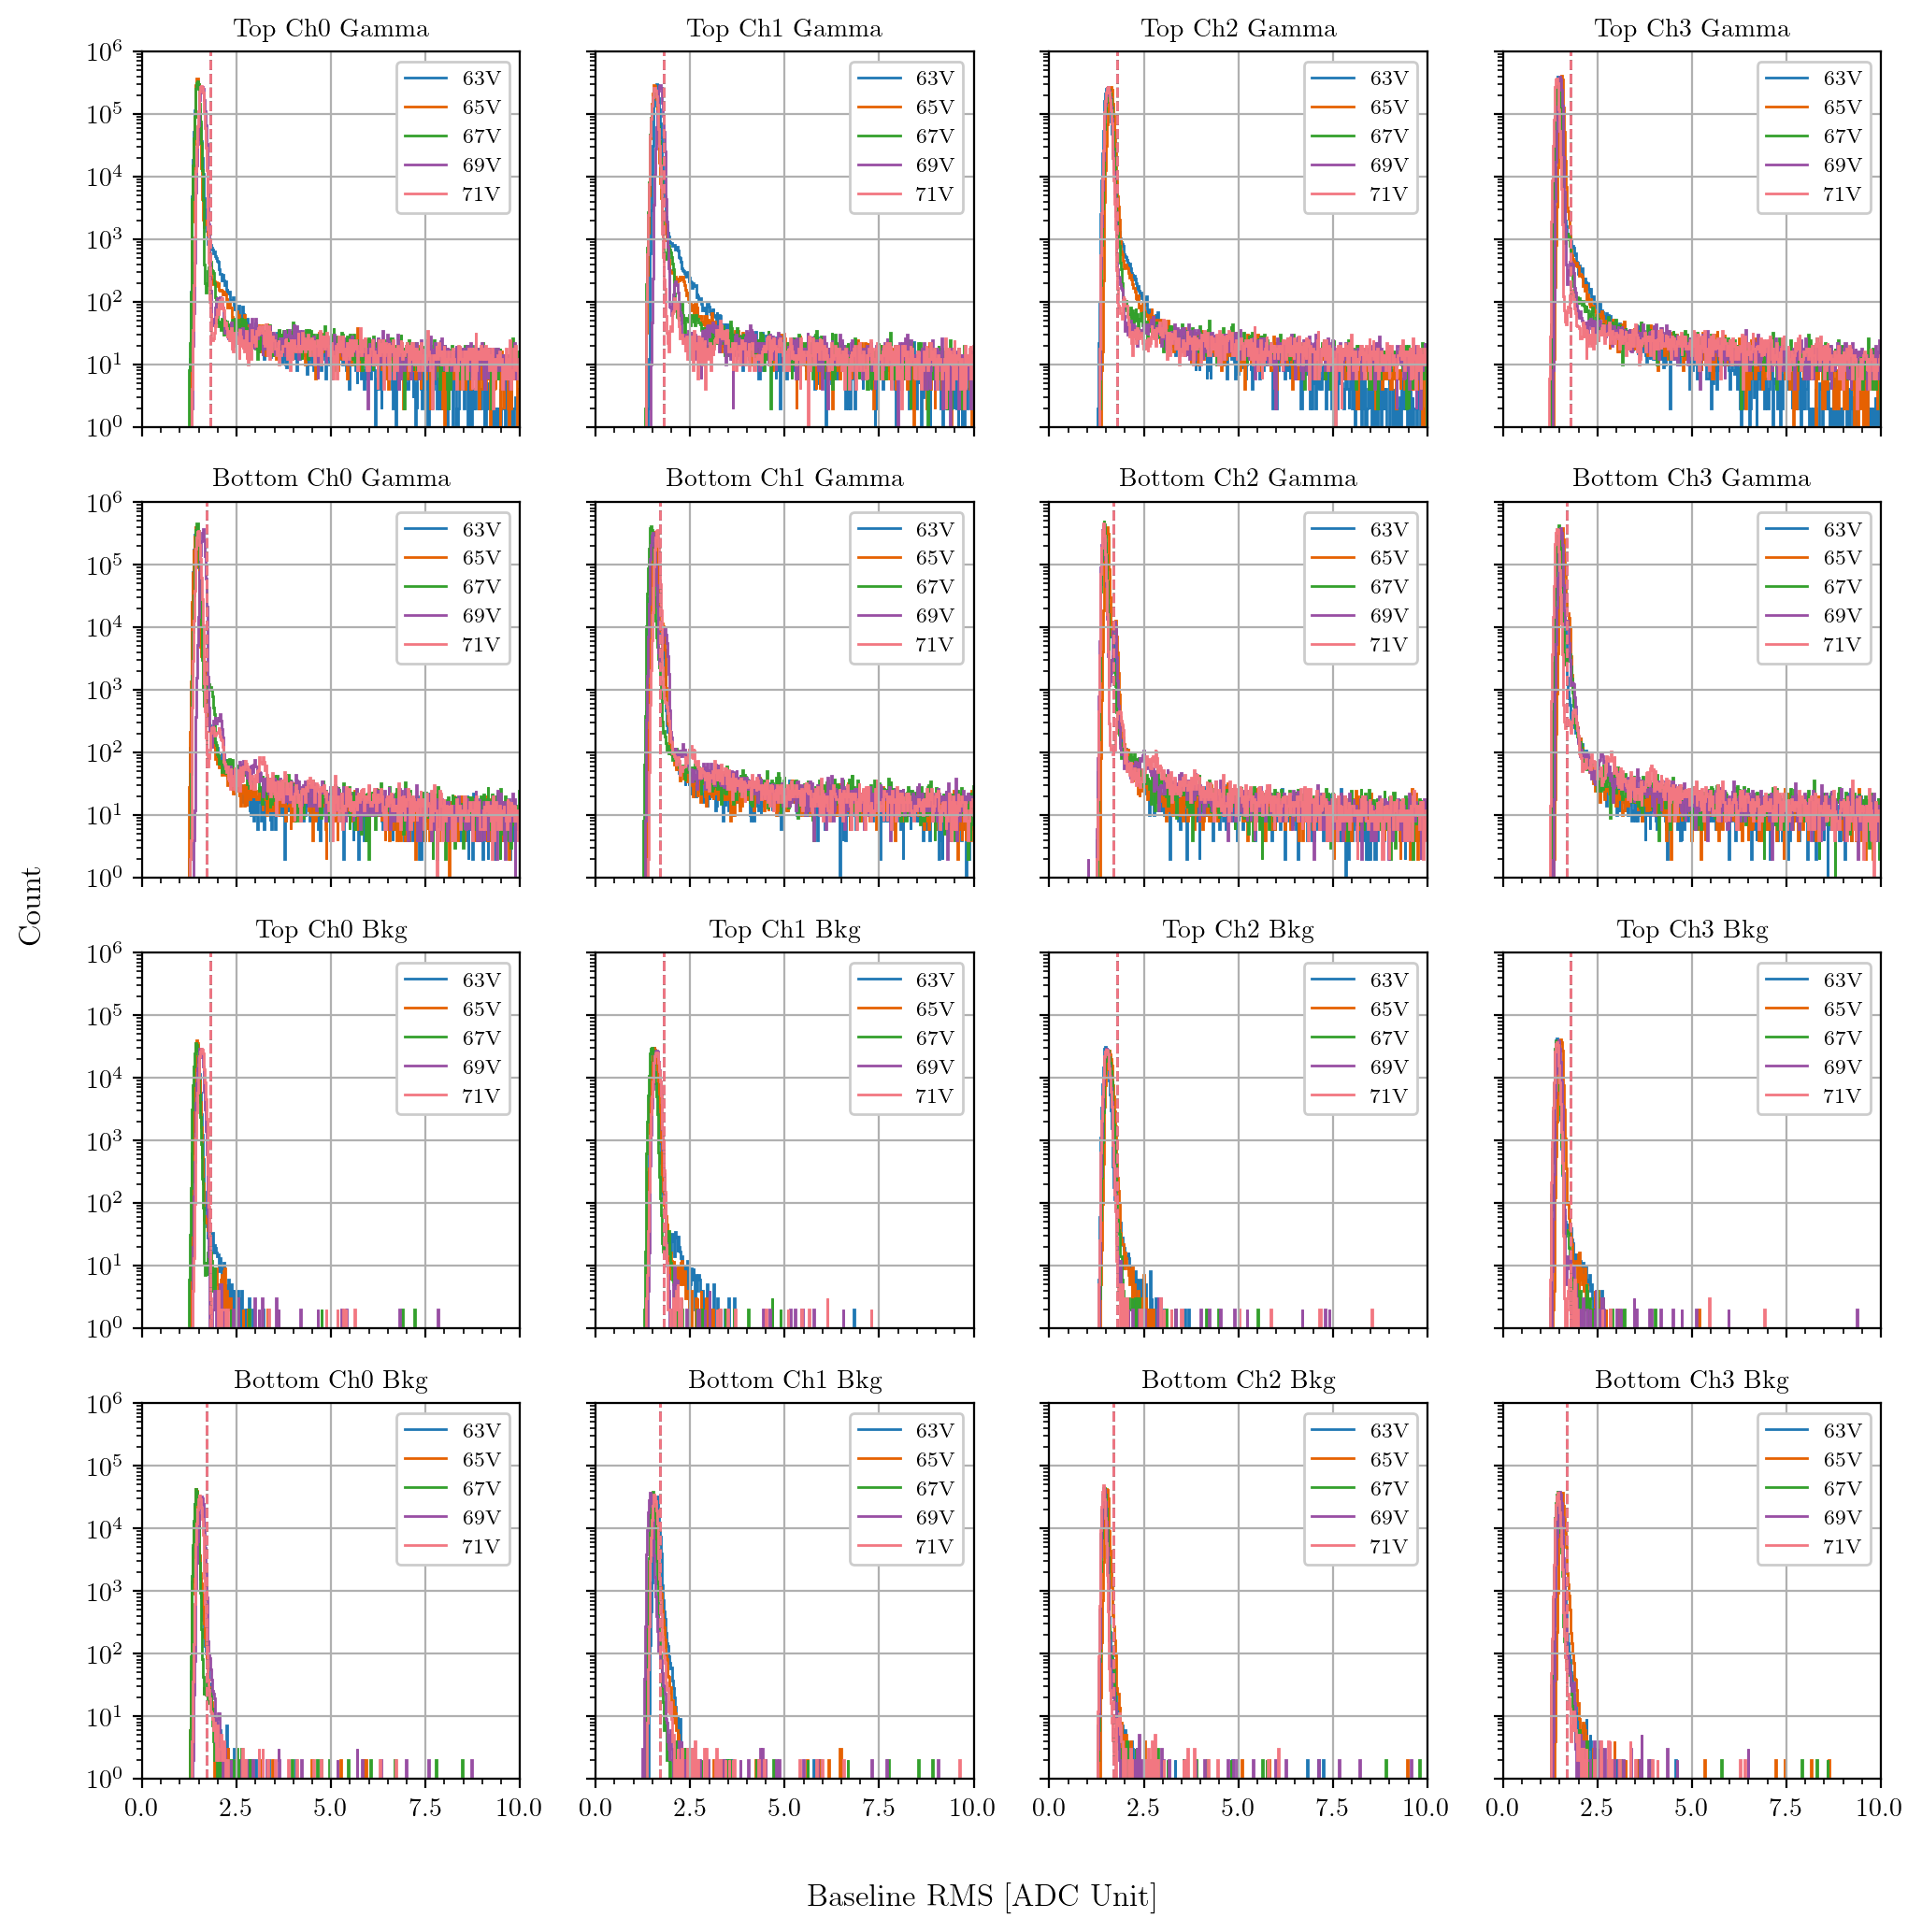

In [86]:
# Make plots for all datasets
# Baseline RMS
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 12)
for i, c in enumerate(cond):
    for j, pos in enumerate(positions):
        for k, ch in enumerate(channels[1:]):
            for l, volt in enumerate(voltages):
                axs[i*2+j, k].stairs(
                    baseline[c][pos][ch][volt]['rms_counts'],
                    baseline[c][pos][ch][volt]['rms_bins'],
                    label=f'{volt}V', color=f'C{l}'
                )
                th = baseline[c][pos][ch][volt]['rms_threshold']
                axs[i*2+j, k].plot([th, th], [1, 1e6], f'C{l}--', linewidth=1)
            axs[i*2+j, k].legend(loc='upper right')
            axs[i*2+j, k].set_ylim(1, 1e6)
            axs[i*2+j, k].set_yscale('log')
            axs[i*2+j, k].minorticks_on()
            axs[i*2+j, k].grid()
            axs[i*2+j, k].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch} {c[0].upper()}{c[1:]}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0.05)
fig.supylabel('Count', x=0.07)

Text(0.07, 0.5, 'Count')

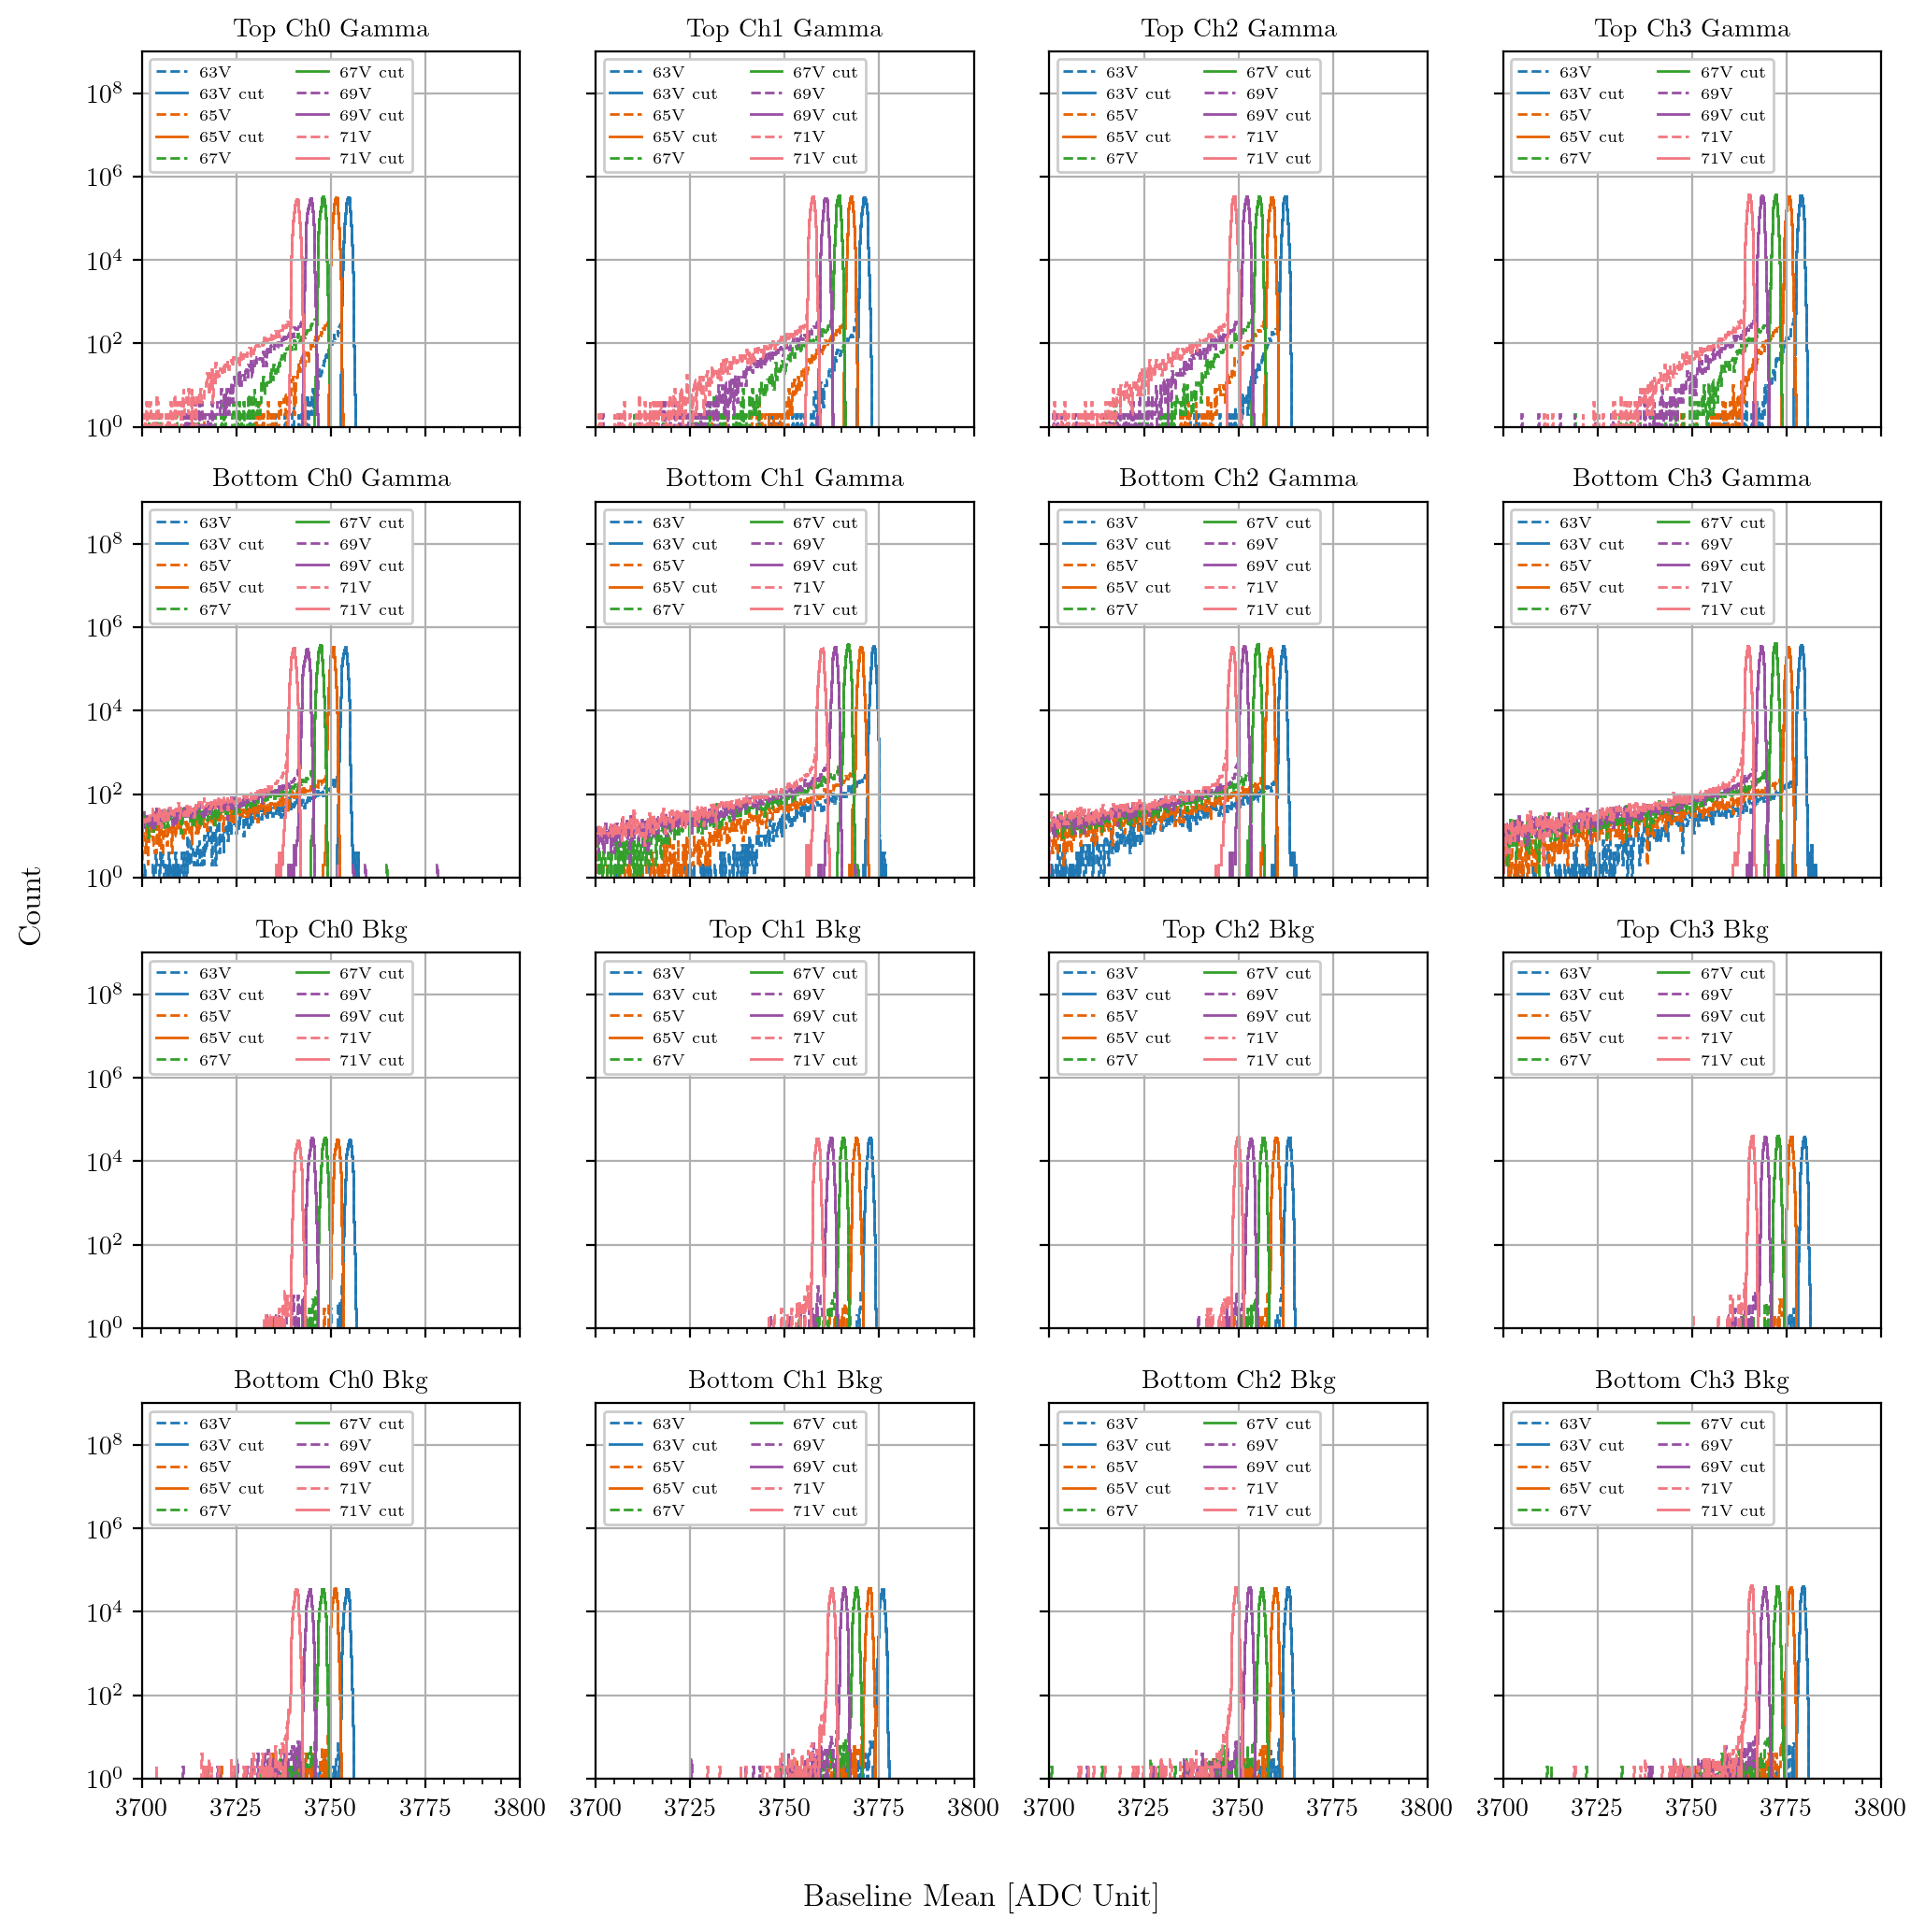

In [87]:
# Make plots for all datasets
# Baseline mean
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 12)
for i, c in enumerate(cond):
    for j, pos in enumerate(positions):
        for k, ch in enumerate(channels[1:]):
            for l, volt in enumerate(voltages):
                axs[i*2+j, k].stairs(
                    baseline[c][pos][ch][volt]['mean_counts'],
                    baseline[c][pos][ch][volt]['mean_bins'],
                    label=f'{volt}V', color=f'C{l}', linestyle='--'
                )
                axs[i*2+j, k].stairs(
                    baseline[c][pos][ch][volt]['mean_counts_cut'],
                    baseline[c][pos][ch][volt]['mean_bins_cut'],
                    label=f'{volt}V cut', color=f'C{l}'
                )
            axs[i*2+j, k].legend(loc='upper left',ncol=2, fontsize=6)
            axs[i*2+j, k].set_ylim(1, 1e9)
            axs[i*2+j, k].set_yscale('log')
            axs[i*2+j, k].minorticks_on()
            axs[i*2+j, k].grid()
            axs[i*2+j, k].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch} {c[0].upper()}{c[1:]}')
fig.supxlabel('Baseline Mean [ADC Unit]', y=0.05)
fig.supylabel('Count', x=0.07)

Plots for bottom ch0 65V gamma


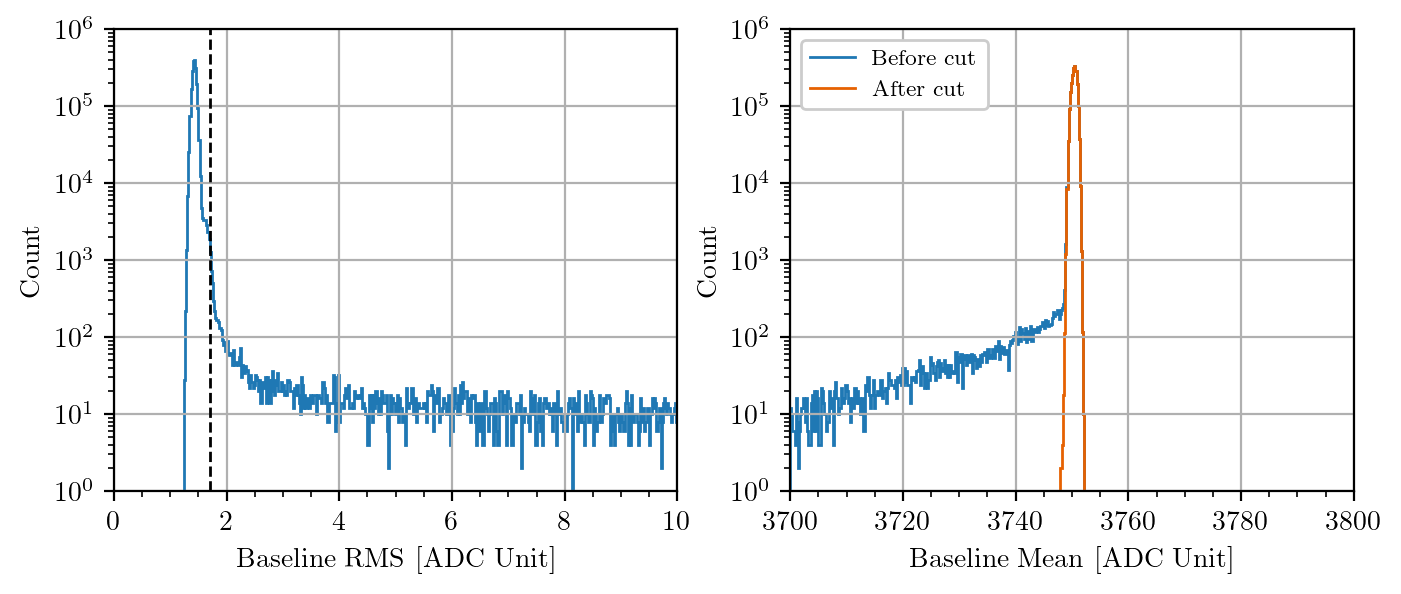

In [88]:
# Make plots for selected dataset
c = 'gamma'
pos = 'bottom'
ch = 0
volt = 65
print(f'Plots for {pos} ch{ch} {volt}V {c}')
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)

# rms
axs[0].stairs(baseline[c][pos][ch][volt]['rms_counts'],
              baseline[c][pos][ch][volt]['rms_bins'])
th = baseline[c][pos][ch][volt]['rms_threshold']
axs[0].plot([th, th], [1, 1e6], 'k--', linewidth=1)
axs[0].set_ylim(1, 1e6)
axs[0].set_yscale('log')
axs[0].set_xlabel('Baseline RMS [ADC Unit]')
axs[0].set_ylabel('Count')
axs[0].minorticks_on()
axs[0].grid()

# mean
axs[1].stairs(baseline[c][pos][ch][volt]['mean_counts'],
              baseline[c][pos][ch][volt]['mean_bins'],
              label='Before cut')
axs[1].stairs(baseline[c][pos][ch][volt]['mean_counts_cut'],
              baseline[c][pos][ch][volt]['mean_bins_cut'],
              label='After cut')
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_ylim(1, 1e6)
axs[1].set_xlim(3700, 3800)
axs[1].set_xlabel('Baseline Mean [ADC Unit]')
axs[1].set_ylabel('Count')
axs[1].minorticks_on()
axs[1].grid()

## Fprompt cut
$F_{\rm prompt}$ is defined as the prompt ($0.5~\rm \mu s$) integral divided by the full ($5~\rm \mu s$) integral.
The ER band of $F_{\rm prompt}\sim0.3$ is clearly visible.
Yet some events have $F_{\rm prompt}\simeq0$, likely due to events triggered on noise with a delayed scintillation pulse.
These are rejected by requiring $F_{\rm prompt}>0.1$.

In [89]:
# Initialize container
fprompt = {}
for c in cond:
    fprompt[c] = {}
    for pos in positions:
        fprompt[c][pos] = {}
        for volt in voltages:
            fprompt[c][pos][volt] = {}

In [90]:
# Produce fprompt 2D histograms
nbinsx = 500
range_minx = -10
range_maxx = 800
nbinsy = 500
range_miny = -0.1
range_maxy = 1

for c in cond:
    for pos in positions:
        for volt in voltages:
            fprompt[c][pos][volt]['fp_counts'], fprompt[c][pos][volt]['fp_xbins'], fprompt[c][pos][volt]['fp_ybins'] = np.histogram2d(
                data_aggr_bslcut[c][pos][volt]['total_pe'], 
                data_aggr_bslcut[c][pos][volt]['fprompt'], 
                bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
            )
            fprompt[c][pos][volt]['fp_counts'] = fprompt[c][pos][volt]['fp_counts'].T
            fprompt[c][pos][volt]['fp_xbins'], fprompt[c][pos][volt]['fp_ybins'] = np.meshgrid(
                fprompt[c][pos][volt]['fp_xbins'], fprompt[c][pos][volt]['fp_ybins']
            )
            fprompt[c][pos][volt]['fp_threshold'] = 0.1

Text(0.07, 0.5, '$F_{\\rm prompt}$')

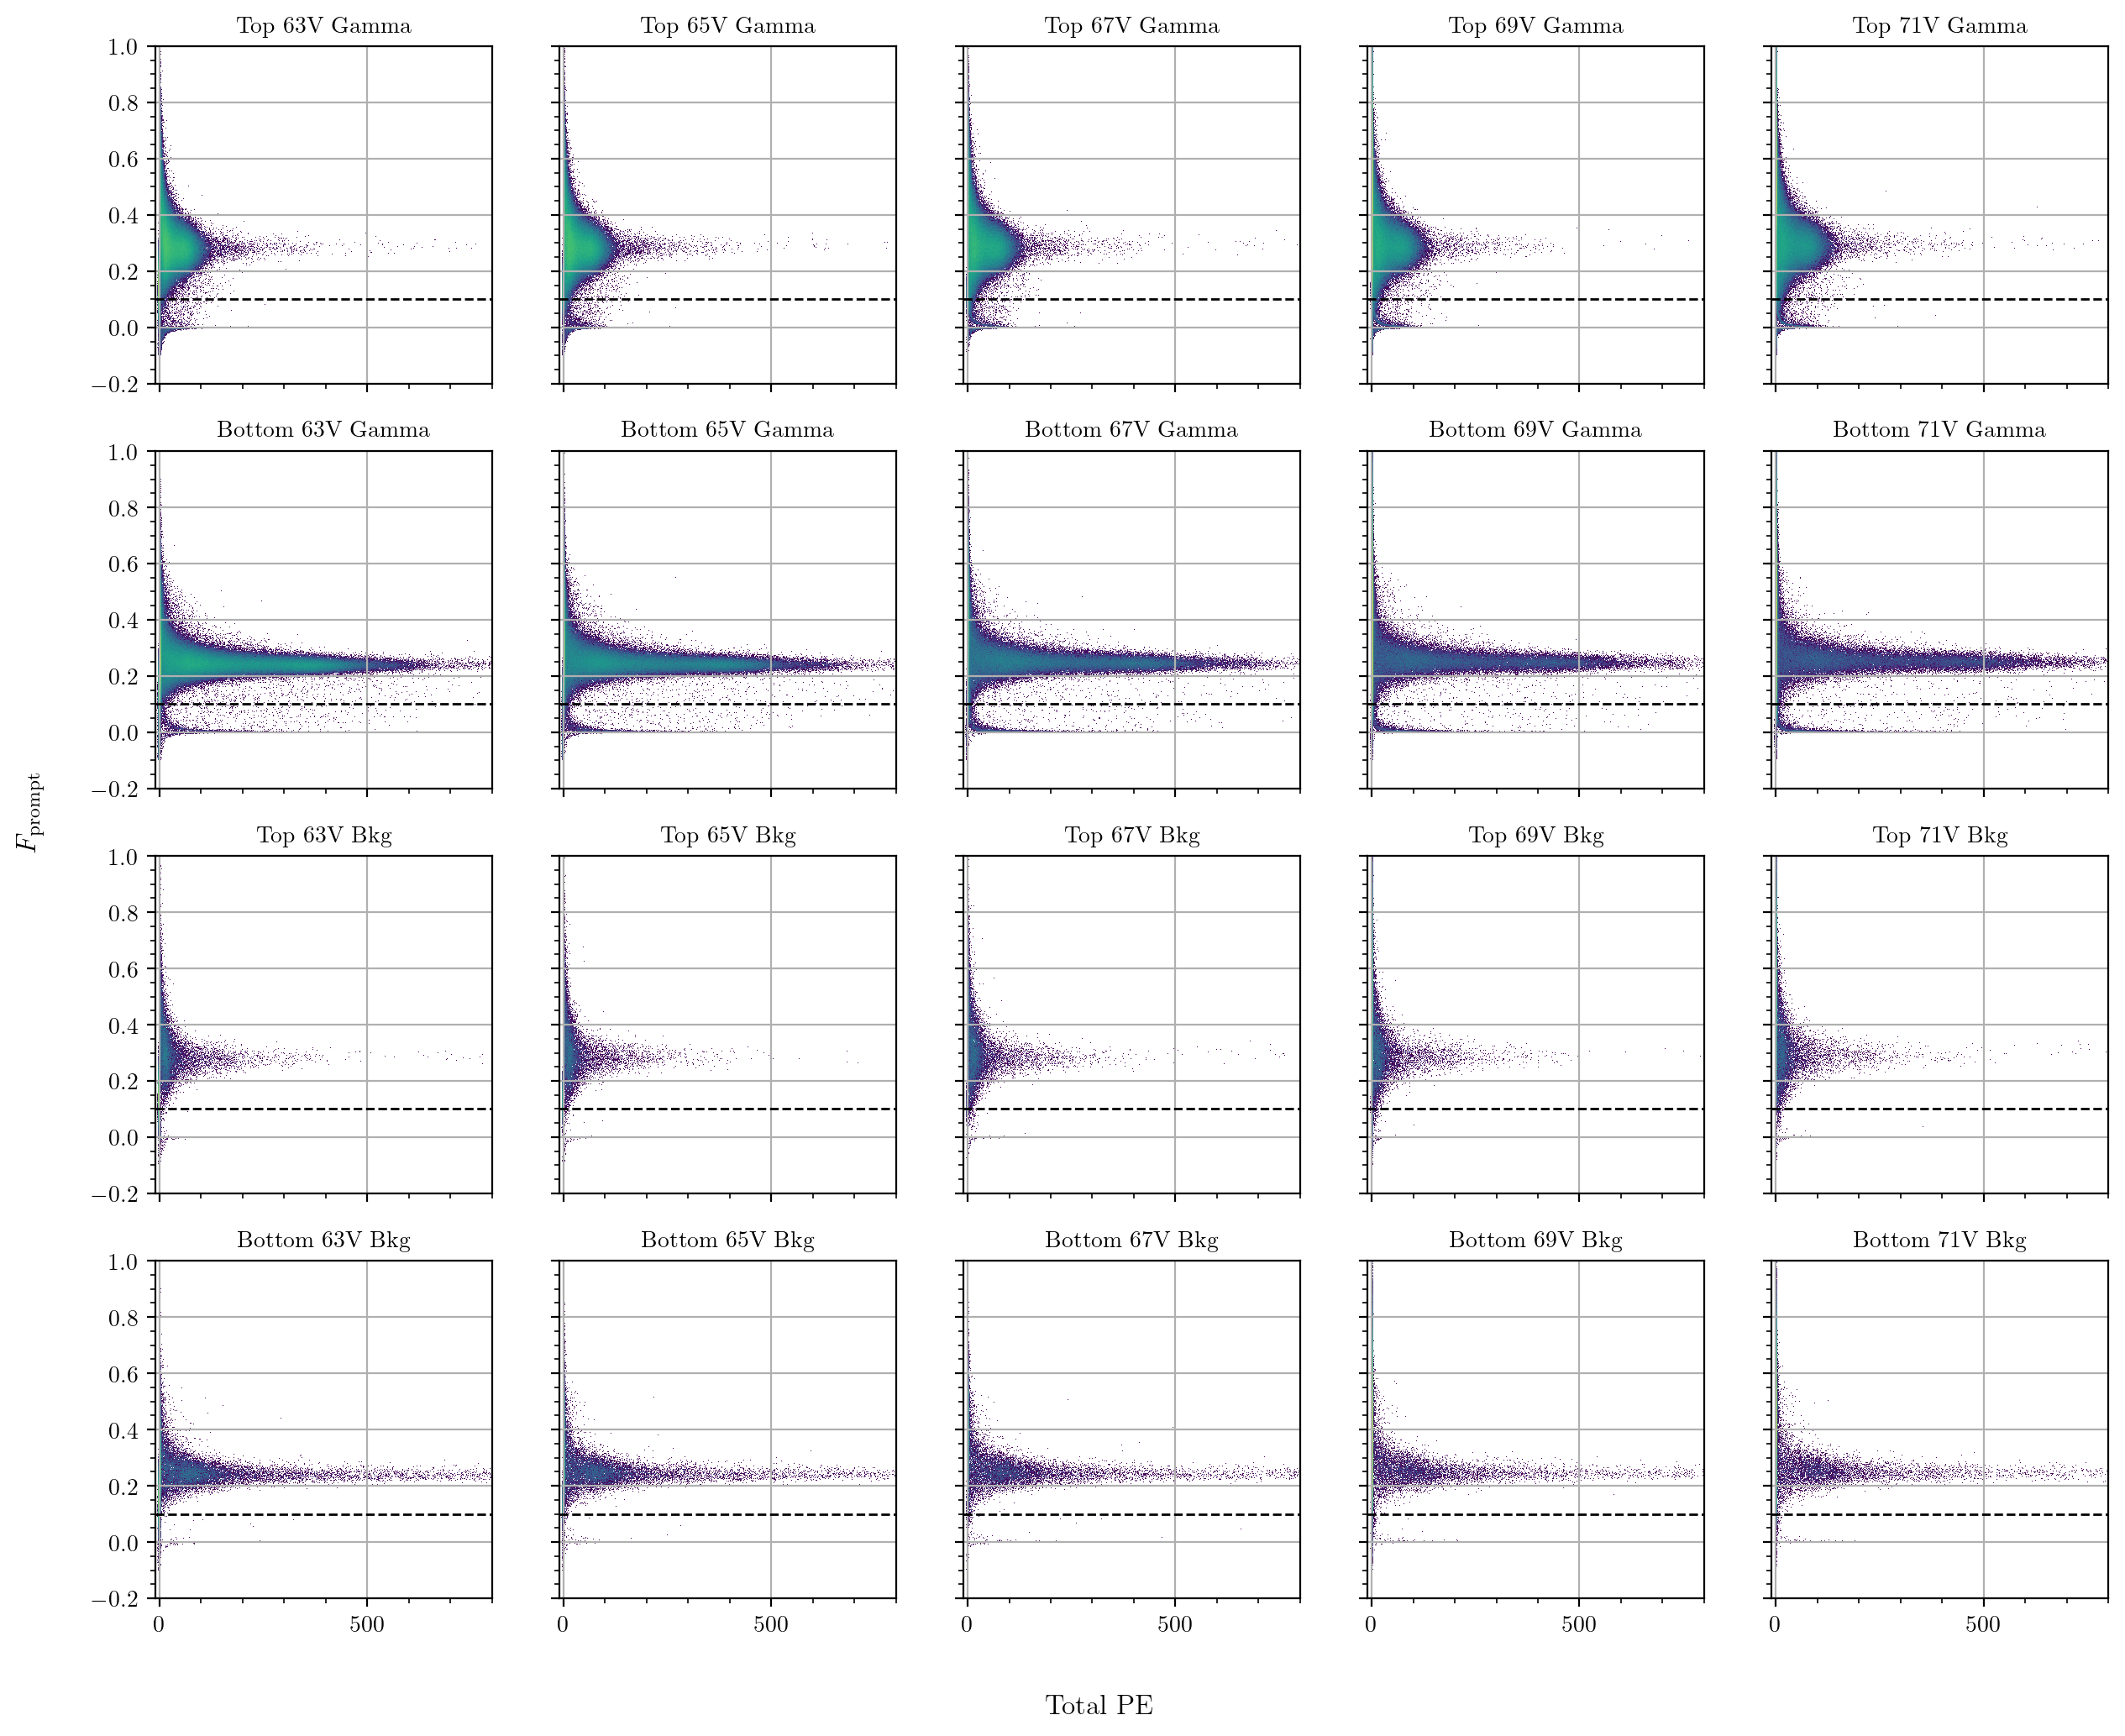

In [91]:
# Make plots for all datasets
# Fprompt
fig, axs = plt.subplots(4, 5, sharex=True, sharey=True)
fig.set_size_inches(15, 12)
for i, c in enumerate(cond):
    for j, pos in enumerate(positions):
        for k, volt in enumerate(voltages):
            axs[i*2+j, k].pcolormesh(
                fprompt[c][pos][volt]['fp_xbins'],
                fprompt[c][pos][volt]['fp_ybins'],
                np.log10(fprompt[c][pos][volt]['fp_counts'])
            )
            th = fprompt[c][pos][volt]['fp_threshold']
            axs[i*2+j, k].plot([-10, 800], [th, th], f'k--', linewidth=1)
            axs[i*2+j, k].set_xlim(-10, 800)
            axs[i*2+j, k].minorticks_on()
            axs[i*2+j, k].grid()
            axs[i*2+j, k].set_title(f'{pos[0].upper()}{pos[1:]} {volt}V {c[0].upper()}{c[1:]}')
fig.supxlabel('Total PE', y=0.05)
fig.supylabel(r'$F_{\rm prompt}$', x=0.07)

Plots for bottom ch0 65V gamma


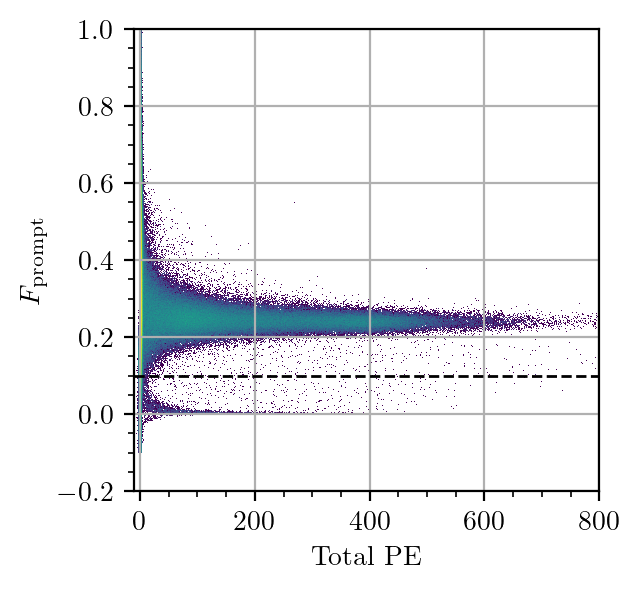

In [92]:
# Make plots for selected dataset
c = 'gamma'
pos = 'bottom'
ch = 0
volt = 65
print(f'Plots for {pos} ch{ch} {volt}V {c}')
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(3, 3)

# Fprompt
axs.pcolormesh(fprompt[c][pos][volt]['fp_xbins'],fprompt[c][pos][volt]['fp_ybins'],np.log10(fprompt[c][pos][volt]['fp_counts']))
th = fprompt[c][pos][volt]['fp_threshold']
axs.plot([-10, 800], [th, th], f'k--', linewidth=1)
axs.set_xlim(-10, 800)
axs.set_xlabel('Total PE')
axs.set_ylabel(r'$F_{\rm prompt}$')
axs.minorticks_on()
axs.grid()

In [93]:
# Calculate cut fraction: fprompt>0.1
data_aggr_allcuts = {}
for c in cond:
    data_aggr_allcuts[c] = {}
    for pos in positions:
        data_aggr_allcuts[c][pos] = {}
        for volt in voltages:  
            data_aggr_allcuts[c][pos][volt] = data_aggr_bslcut[c][pos][volt].loc[ 
                data_aggr_bslcut[c][pos][volt]['fprompt']>fprompt[c][pos][volt]['fp_threshold'] 
            ]
            cut_fraction = 1-data_aggr_allcuts[c][pos][volt].shape[0]/data_aggr_bslcut[c][pos][volt].shape[0]
            data_aggr_bslcut[c][pos][volt] = None # clear memory
            fprompt[c][pos][volt]['cut_fraction'] = cut_fraction
            print(f'{pos} {volt}V {c} cut fraction = {cut_fraction*100:.5f}%')
# clear memory
data_aggr_bslcut = None

top 63V gamma cut fraction = 24.60532%
top 65V gamma cut fraction = 21.26377%
top 67V gamma cut fraction = 21.07533%
top 69V gamma cut fraction = 19.61964%
top 71V gamma cut fraction = 17.30825%
bottom 63V gamma cut fraction = 15.06341%
bottom 65V gamma cut fraction = 15.06854%
bottom 67V gamma cut fraction = 14.51881%
bottom 69V gamma cut fraction = 12.90003%
bottom 71V gamma cut fraction = 10.78516%
top 63V bkg cut fraction = 42.26707%
top 65V bkg cut fraction = 41.24871%
top 67V bkg cut fraction = 37.59466%
top 69V bkg cut fraction = 35.53652%
top 71V bkg cut fraction = 32.75587%
bottom 63V bkg cut fraction = 36.47056%
bottom 65V bkg cut fraction = 34.17455%
bottom 67V bkg cut fraction = 26.14827%
bottom 69V bkg cut fraction = 20.99939%
bottom 71V bkg cut fraction = 16.78068%


In [94]:
# Print container keys
print('fprompt keys: ', list(
    fprompt[cond[0]][positions[0]][voltages[0]].keys()))
print('data_aggr_allcuts keys: ', list(
    data_aggr_allcuts[cond[0]][positions[0]][voltages[0]].keys()))

fprompt keys:  ['fp_counts', 'fp_xbins', 'fp_ybins', 'fp_threshold', 'cut_fraction']
data_aggr_allcuts keys:  ['total_pe', 'fprompt', 'baseline_rms0', 'baseline_rms1', 'baseline_rms2', 'baseline_rms3']


## Draw spectra
The PE count $N_{\rm PE}$ is reconstructed as
$$N_{\rm PE}=\frac{I}{Q_{\rm peak}(1+Q_{\rm AP})/(1-p)}$$
where $I$ is the time integral ($5~\rm\mu s$) of the unfiltered waveform.
Ideally, this corrects for the direct crosstalk and afterpulsing effects of increasing light yield.

The spectra with source are subtracted by that without source (backgrounds only).
The spectra are normalized with the background sideband ($N_{\rm PE}>170$ for top and $N_{\rm PE}>900$ for bottom).

In [95]:
# Initialize container
spectra = {}
types = ['gamma','bkg','subtract']
for t in types:
    spectra[t] = {}
    for pos in positions:
        spectra[t][pos] = {}
        for volt in voltages:
            spectra[t][pos][volt] = {}

In [96]:
# Region above norm_bounds is background only. Use event count in this region to normalize spectrum.
norm_bounds = {'top':[150,160,170,180,190], 'bottom':[800,860,920,980,1040]}
for t in types[:-1]:
    for pos in positions:
        for i,volt in enumerate(voltages):
            if pos=='top':
                range_min = 0
                range_max = 500
                nbins = 750
            elif pos=='bottom':
                range_min = 0
                range_max = 3000
                nbins = 750
            spectra[t][pos][volt]['norm_bound'] = norm_bounds[pos][i]
            spectra[t][pos][volt]['counts'], spectra[t][pos][volt]['bins'] = np.histogram(
                data_aggr_allcuts[t][pos][volt]['total_pe'], 
                bins=nbins, range=(range_min, range_max)
            )
            spectra[t][pos][volt]['errs'] = np.sqrt(spectra[t][pos][volt]['counts'])
            # normalization
            spectra[t][pos][volt]['norm'] = np.sum(
                spectra[t][pos][volt]['counts'][
                    spectra[t][pos][volt]['bins'][:-1]>spectra[t][pos][volt]['norm_bound']
                ]
            )

for pos in positions:
    for volt in voltages:
        spectra['subtract'][pos][volt]['bins'] = np.copy(spectra['gamma'][pos][volt]['bins'])
        spectra['subtract'][pos][volt]['norm_bound'] = spectra['gamma'][pos][volt]['norm_bound']
        spectra['subtract'][pos][volt]['norm'] = 1
        spectra['subtract'][pos][volt]['counts'] = spectra['gamma'][pos][volt]['counts']/spectra['gamma'][pos][volt]['norm'] - spectra['bkg'][pos][volt]['counts']/spectra['bkg'][pos][volt]['norm']
        spectra['subtract'][pos][volt]['errs'] = ((spectra['gamma'][pos][volt]['errs']/spectra['gamma'][pos][volt]['norm'])**2 + (spectra['bkg'][pos][volt]['errs']/spectra['bkg'][pos][volt]['norm'])**2)**0.5
# data_aggr_allcuts = None

Text(0.07, 0.5, 'Count')

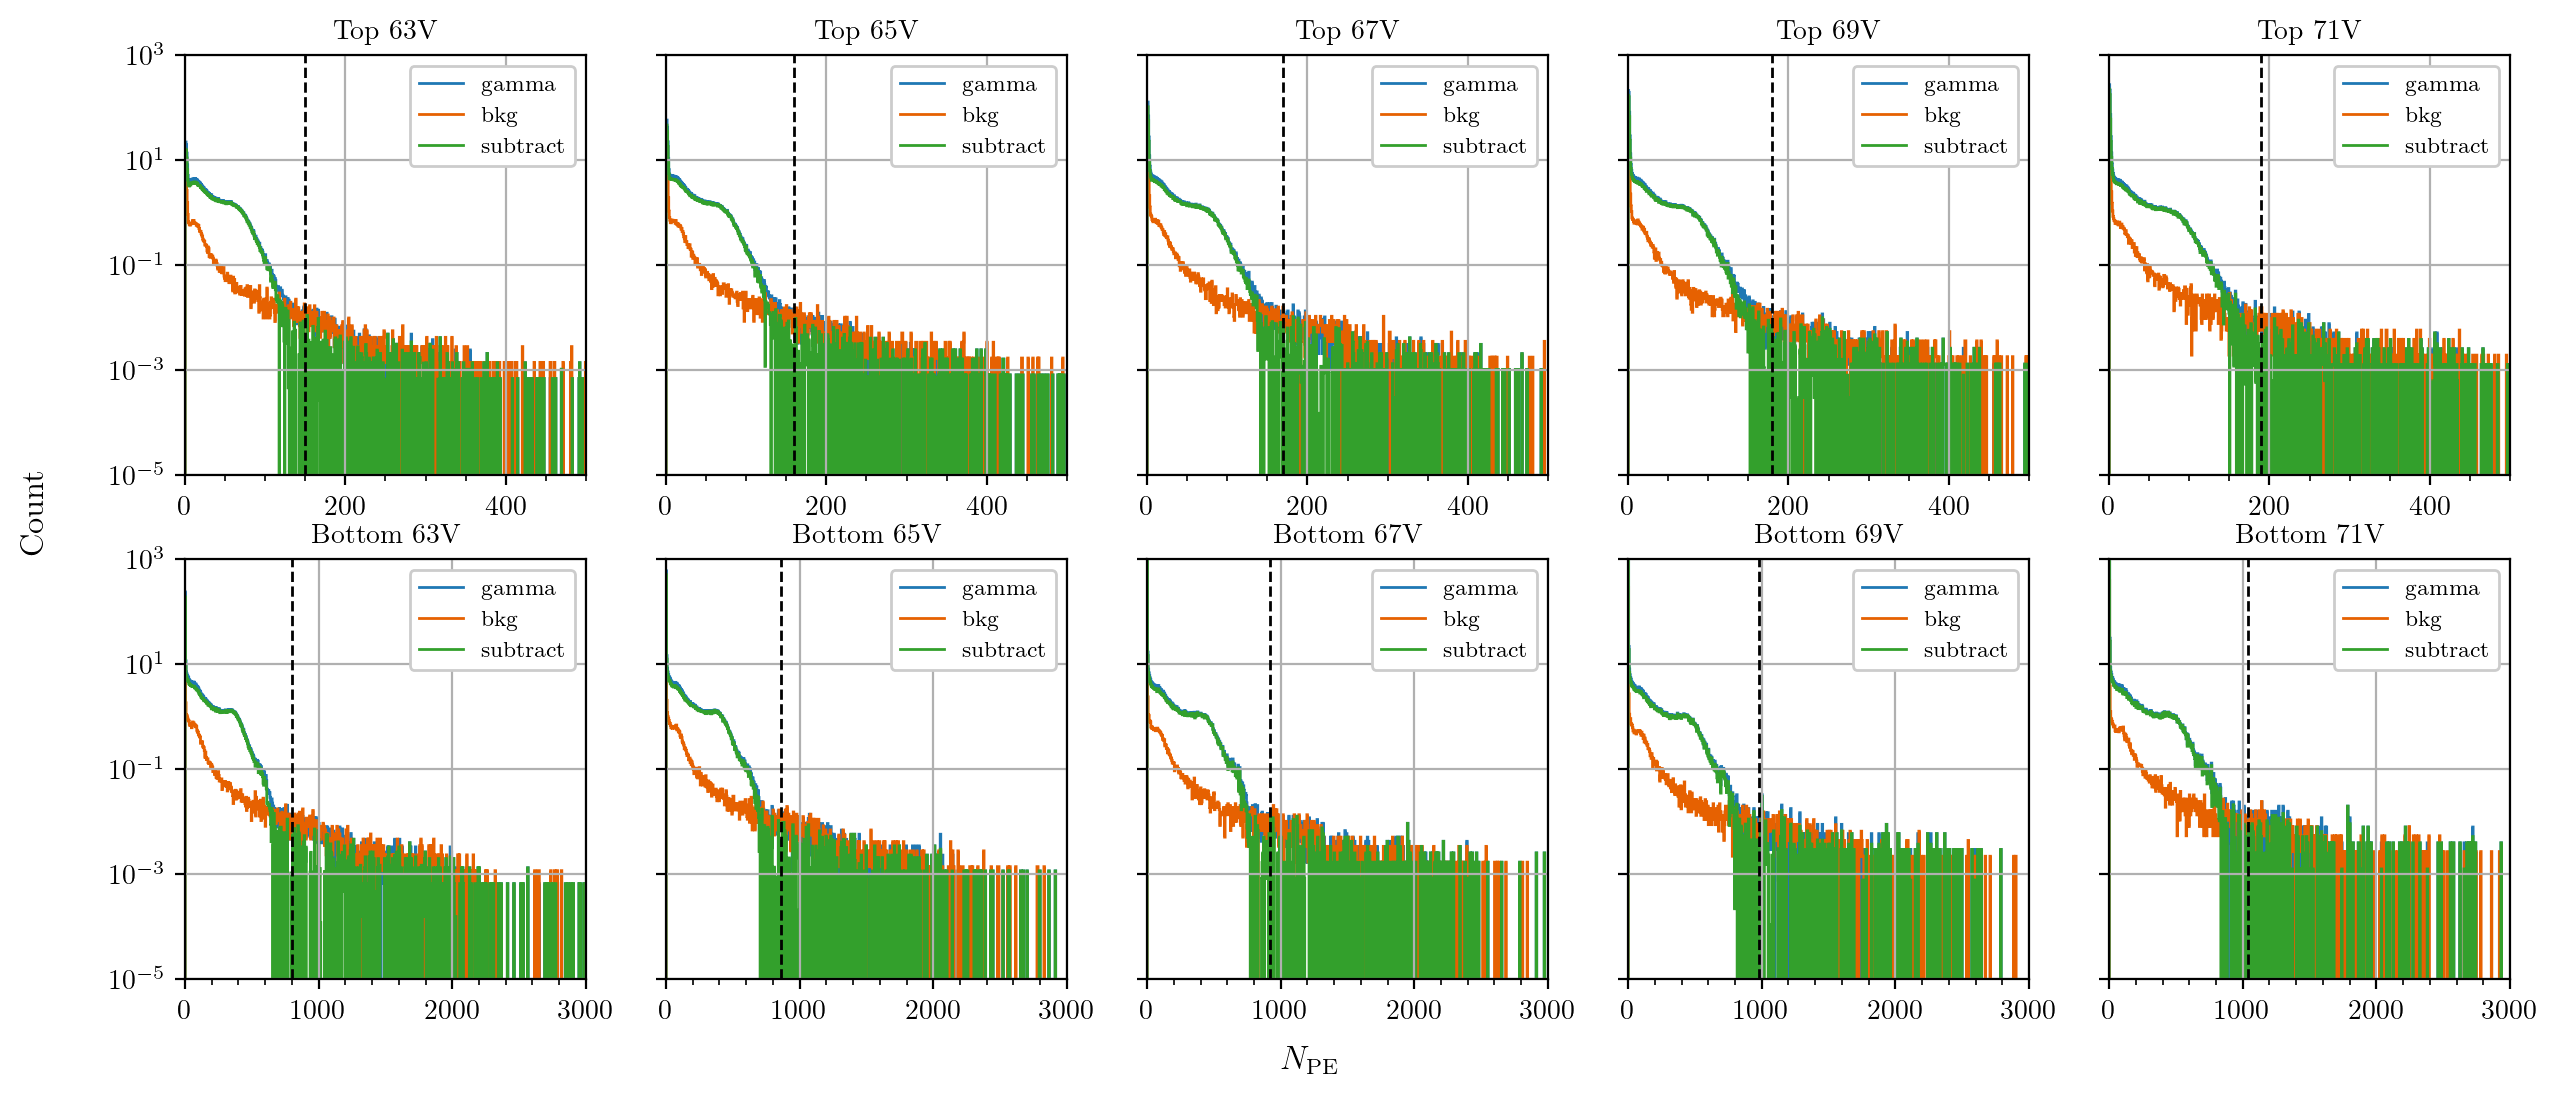

In [97]:
# Make plots for all datasets
# With source, without source, and background subtracted
fig, axs = plt.subplots(2, 5, sharex=False, sharey=True)
fig.set_size_inches(15, 6)
for i, pos in enumerate(positions):
    for j, volt in enumerate(voltages):
        for k, t in enumerate(types):
            axs[i, j].stairs(
                spectra[t][pos][volt]['counts']/spectra[t][pos][volt]['norm'],
                spectra[t][pos][volt]['bins'],
                label=f'{t}', color=f'C{k}'
            )
        th = spectra['gamma'][pos][volt]['norm_bound']
        axs[i, j].plot([th, th], [1e-5, 1e3], f'k--', linewidth=1)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_ylim(1e-5, 1e3)
        axs[i,j].set_xlim(spectra[t][pos][volt]['bins'][0],spectra[t][pos][volt]['bins'][-1])
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} {volt}V')
fig.supxlabel(r'$N_{\rm PE}$', y=0.03)
fig.supylabel('Count', x=0.07)

## Detector response model
Consider light yield non-uniformity. Let $\alpha$ be the relative RMS variation:
$$L'_y \sim \mathcal{N}(\mu = L_y, \sigma=\alpha L_y)$$
Fix Fano factor to $1+p$ derived from compound Poisson distribution. The $(1-p)^2$ factor is canceled out due to the DiCT correction in PE reconstruction.
This Fano factor accounts for photon transport and direct crosstalk effects.
$$N_{\rm PE} \sim \mathcal{N}(\mu=L'_y E_{\rm dep}, \sigma=\sqrt{(1+p)L'_y E_{\rm dep}})$$

In [98]:
def chisquare_two_hist_new(ly, alpha, data_hist, data_hist_bins, data_hist_err, tree, p_dict, range_pe):
    xmin = data_hist_bins[0]
    xmax = data_hist_bins[-1]
    nbins = data_hist_bins.shape[0]-1
    simulated_pe = []
    for i,ev in enumerate(tree):
        lyr = normal(ly, ly*alpha)
        simulated_pe.append(normal(lyr*ev.Edep, np.sqrt((1+p_dict)*lyr*ev.Edep)))
    hSimPE, hSimPE_bins = np.histogram(simulated_pe, bins=nbins, range=(xmin,xmax))
    hSimPE_err = np.sqrt(hSimPE)
    simulated_pe = None
    norm_sim = np.sum(data_hist[(data_hist_bins[:-1]<range_pe[1]) & (data_hist_bins[:-1]>range_pe[0])]) / np.sum(hSimPE[(hSimPE_bins[:-1]<range_pe[1]) & (hSimPE_bins[:-1]>range_pe[0])])
    hSimPE = hSimPE*norm_sim
    hSimPE_err = hSimPE_err*norm_sim
    chi_square = np.dot(
        (data_hist_bins[:-1]<range_pe[1]) & (data_hist_bins[:-1]>range_pe[0]), 
        np.nan_to_num((data_hist - hSimPE)**2/(data_hist_err**2 + hSimPE_err**2))
    )
    return chi_square

# Chi-square map
Light yield $L_y$ and non-uniformity $\alpha$ are the fit parameters.
The simulated spectrum is generated for each ($L_y$,$\alpha$) combination.
The $\chi^2$ maps have statistical noises, so it is impossible to fit using a minimizer.
Instead, we fit the $\chi^2$ maps with $-2\ln\mathcal{L}$, where $\mathcal{L}$ is bivariate Gaussian distribution.
The best-fit parameters and the covariance matrix are obtained from $\mathcal{L}$
For interval estimation, 68% CL in 2D corresponds to 1.515 $\sigma$.

In [99]:
from scipy.stats import multivariate_normal
from scipy.stats import norm

def gauss2d(xy, ly, fano, Sx, Sy, theta, c):
    sxx = Sx**2*np.cos(theta)**2+Sy**2*np.sin(theta)**2
    sxy = (Sx**2-Sy**2)*np.sin(theta)*np.cos(theta)
    syy = Sx**2*np.sin(theta)**2+Sy**2*np.cos(theta)**2
    return -2*np.log(2*np.pi*Sx*Sy*multivariate_normal(mean=[ly,fano], cov=[[sxx, sxy],[sxy, syy]]).pdf(xy))+c

## Read DiCT probability from csv file

In [100]:
import csv
p_dict = {'top':{}, 'bottom':{}}
syserr2 = {'top':{}, 'bottom':{}}
for volt in voltages:
    p_dict['top'][volt] = 0
    p_dict['bottom'][volt] = 0
    syserr2['top'][volt] = 0
    syserr2['bottom'][volt] = 0
    with open('data/calibration/calibration_1122_{}V.csv'.format(volt)) as f:
        r = csv.reader(f)
        line_count = 0
        for row in r:
            if line_count>0:
                if line_count<=4:
                    p_dict['top'][volt] += float(row[3])
                    syserr2['top'][volt] += (float(row[6])/float(row[5]))**2 + (float(row[4])/(1-float(row[3])))**2
                else:
                    p_dict['bottom'][volt] += float(row[3])
                    syserr2['bottom'][volt] += (float(row[6])/float(row[5]))**2 + (float(row[4])/(1-float(row[3])))**2
            line_count += 1
        p_dict['top'][volt] /= 4
        p_dict['bottom'][volt] /= 4
print('DiCT probability:')
print(p_dict)
print('Systematics from calibration:')
print(syserr2)

DiCT probability:
{'top': {63: 0.13195578512723458, 65: 0.18188803539339343, 67: 0.2355293684529121, 69: 0.2886990240147077, 71: 0.345974974496487}, 'bottom': {63: 0.11440878038914228, 65: 0.16311037836942024, 67: 0.21193400608209784, 69: 0.2656851917977776, 71: 0.3204535673134356}}
Systematics from calibration:
{'top': {63: 0.00010170273622978941, 65: 7.936047517756038e-05, 67: 9.925978910715281e-05, 69: 0.00025927239994209475, 71: 0.0005362585529311584}, 'bottom': {63: 0.00010837345297953766, 65: 0.000184344187817076, 67: 0.0002636862676438766, 69: 0.0003460134913900682, 71: 0.0004551416119846962}}


## Fit

In [101]:
# Initialize container
spectrum_fit = {}
for pos in positions:
    spectrum_fit[pos] = {}
    for volt in voltages:
        spectrum_fit[pos][volt] = {}

In [110]:
ly_guess = {'top':[0.148, 0.158, 0.170, 0.179, 0.189], 'bottom':[0.83, 0.895, 0.975, 1.03, 1.09]}
fit_min = {'top':[40,40,40,40,40], 'bottom':[200,200,200,200,200]}
fit_max = {'top':[140,145,150,155,160], 'bottom':[700,750,800,850,900]}
for pos in positions:
    for iv,volt in enumerate(voltages):
        print(f'Running for {pos} {volt}V')
        data_hist = spectra['subtract'][pos][volt]['counts']
        data_hist_bins = spectra['subtract'][pos][volt]['bins']
        data_hist_err = spectra['subtract'][pos][volt]['errs']

        spectrum_fit[pos][volt]['data'] = {
            'bins':spectra['subtract'][pos][volt]['bins'],
            'x':0.5*(spectra['subtract'][pos][volt]['bins'][1:]+spectra['subtract'][pos][volt]['bins'][:-1]), 
            'y':spectra['subtract'][pos][volt]['counts'], 
            'yerr':spectra['subtract'][pos][volt]['errs']
        }

        file = ROOT.TFile("/scratch/gpfs/as111/root/pu_lar_cs137_Edep.root", "read")
        tr = file.Get("trEdep")

        lys = np.linspace(ly_guess[pos][iv]*0.97, ly_guess[pos][iv]*1.03, 10)
        alphas = np.linspace(0.03, 0.10, 10)
        X,Y = np.meshgrid(lys, alphas)

        # Spectrum fit range
        spectrum_fit[pos][volt]['fit_range'] = [fit_min[pos][iv], fit_max[pos][iv]]

        chi2map = np.array([[chisquare_two_hist_new(
            ly_, alpha_, data_hist, data_hist_bins, data_hist_err, tr, p_dict[pos][volt], spectrum_fit[pos][volt]['fit_range']
        ) for ly_ in lys] for alpha_ in alphas])
        min_chi2 = np.min(chi2map)
        chi2map = chi2map - min_chi2
        spectrum_fit[pos][volt]['chi2'] = {'x': X, 'y':Y, 'z':chi2map}

        # Fit chi-square to find minimum and errors
        popt,pcov = curve_fit(
            gauss2d, 
            np.stack((X, Y),axis=-1).reshape(-1,2), 
            chi2map.flatten(), 
            p0=[ly_guess[pos][iv], 0.08, 0.002, 0.006, 0.2, 150], 
            maxfev=10000
        )
        spectrum_fit[pos][volt]['chi2']['min_fit'] = popt[5]
        
        # Print best fit values and 68% CL
        ly_fit = popt[0]
        alpha_fit = popt[1]
        ly_68 = func.error_distance(df=2,sigma=1)*np.sqrt(popt[2]**2*np.cos(popt[4])**2+popt[3]**2*np.sin(popt[4])**2)
        alpha_68 = func.error_distance(df=2,sigma=1)*np.sqrt(popt[2]**2*np.sin(popt[4])**2+popt[3]**2*np.cos(popt[4])**2)
        print('Ly={:.3f}+/-{:.3f} PE/keV  alpha={:.3f}+/-{:.3f} (68% CL)'.format(ly_fit, ly_68, alpha_fit, alpha_68))
        spectrum_fit[pos][volt]['ly'] = ly_fit
        spectrum_fit[pos][volt]['ly_err'] = ly_68
        spectrum_fit[pos][volt]['alpha'] = alpha_fit
        spectrum_fit[pos][volt]['alpha_err'] = alpha_68

        simPE = []
        nev = 0
        for i,ev in enumerate(tr):
            for j in range(1):
                ly_random = normal(loc=ly_fit,scale=ly_fit*alpha_fit) 
                simPE.append(normal(ly_random*tr.Edep, np.sqrt((1+p_dict[pos][volt])*ly_random*tr.Edep)))
                nev += 1
        print('{} events simulated'.format(nev))
        file.Close()

        xmin = data_hist_bins[0]
        xmax = data_hist_bins[-1]
        nbins = data_hist_bins.shape[0]-1
        hSim, hSim_bins = np.histogram(
            simPE, 
            bins=data_hist_bins.shape[0]-1, 
            range=(data_hist_bins[0], data_hist_bins[-1])
        )
        hSimErr = np.sqrt(hSim)
        norm_ = np.sum(data_hist[
            (data_hist_bins[:-1]<spectrum_fit[pos][volt]['fit_range'][1]) & (data_hist_bins[:-1]>spectrum_fit[pos][volt]['fit_range'][0])
        ])
        norm_ /= np.sum(hSim[
            (data_hist_bins[:-1]<spectrum_fit[pos][volt]['fit_range'][1]) & (data_hist_bins[:-1]>spectrum_fit[pos][volt]['fit_range'][0])
        ])
        hSim = hSim*norm_
        hSimErr = hSimErr*norm_

        spectrum_fit[pos][volt]['sim'] = {
            'bins':hSim_bins,
            'x':0.5*(hSim_bins[1:]+hSim_bins[:-1]), 
            'y':hSim,
            'yerr':hSimErr
        }
        spectrum_fit[pos][volt]['chi2']['min_toy'] = np.dot(
            np.nan_to_num((hSim-data_hist)**2/(hSimErr**2 + data_hist_err**2)), 
            (data_hist_bins[:-1]<spectrum_fit[pos][volt]['fit_range'][1]) & (data_hist_bins[:-1]>spectrum_fit[pos][volt]['fit_range'][0])
        )
        spectrum_fit[pos][volt]['chi2']['dof'] = np.sum(
            (data_hist_bins[:-1]<spectrum_fit[pos][volt]['fit_range'][1]) & (data_hist_bins[:-1]>spectrum_fit[pos][volt]['fit_range'][0])
        ) - 4

        # (Ly,F) range
        XX,YY = np.meshgrid(np.linspace(lys[0],lys[-1],100),np.linspace(alphas[0],alphas[-1],100))
        spectrum_fit[pos][volt]['chi2']['xfit'] = XX
        spectrum_fit[pos][volt]['chi2']['yfit'] = YY
        spectrum_fit[pos][volt]['chi2']['zfit'] = gauss2d(np.dstack((XX,YY)),*popt)

Running for top 63V
Ly=0.148+/-0.001 PE/keV  alpha=0.073+/-0.011 (68% CL)
174324 events simulated
Running for top 65V
Ly=0.159+/-0.001 PE/keV  alpha=0.066+/-0.013 (68% CL)
174324 events simulated
Running for top 67V
Ly=0.170+/-0.001 PE/keV  alpha=0.061+/-0.011 (68% CL)
174324 events simulated
Running for top 69V
Ly=0.178+/-0.001 PE/keV  alpha=0.065+/-0.009 (68% CL)
174324 events simulated
Running for top 71V
Ly=0.188+/-0.001 PE/keV  alpha=0.072+/-0.011 (68% CL)
174324 events simulated
Running for bottom 63V
Ly=0.830+/-0.002 PE/keV  alpha=0.079+/-0.005 (68% CL)
174324 events simulated
Running for bottom 65V
Ly=0.897+/-0.003 PE/keV  alpha=0.083+/-0.005 (68% CL)
174324 events simulated
Running for bottom 67V
Ly=0.978+/-0.003 PE/keV  alpha=0.078+/-0.005 (68% CL)
174324 events simulated
Running for bottom 69V
Ly=1.032+/-0.004 PE/keV  alpha=0.079+/-0.006 (68% CL)
174324 events simulated
Running for bottom 71V
Ly=1.089+/-0.004 PE/keV  alpha=0.078+/-0.007 (68% CL)
174324 events simulated


Text(0.02, 0.5, '$\\alpha$')

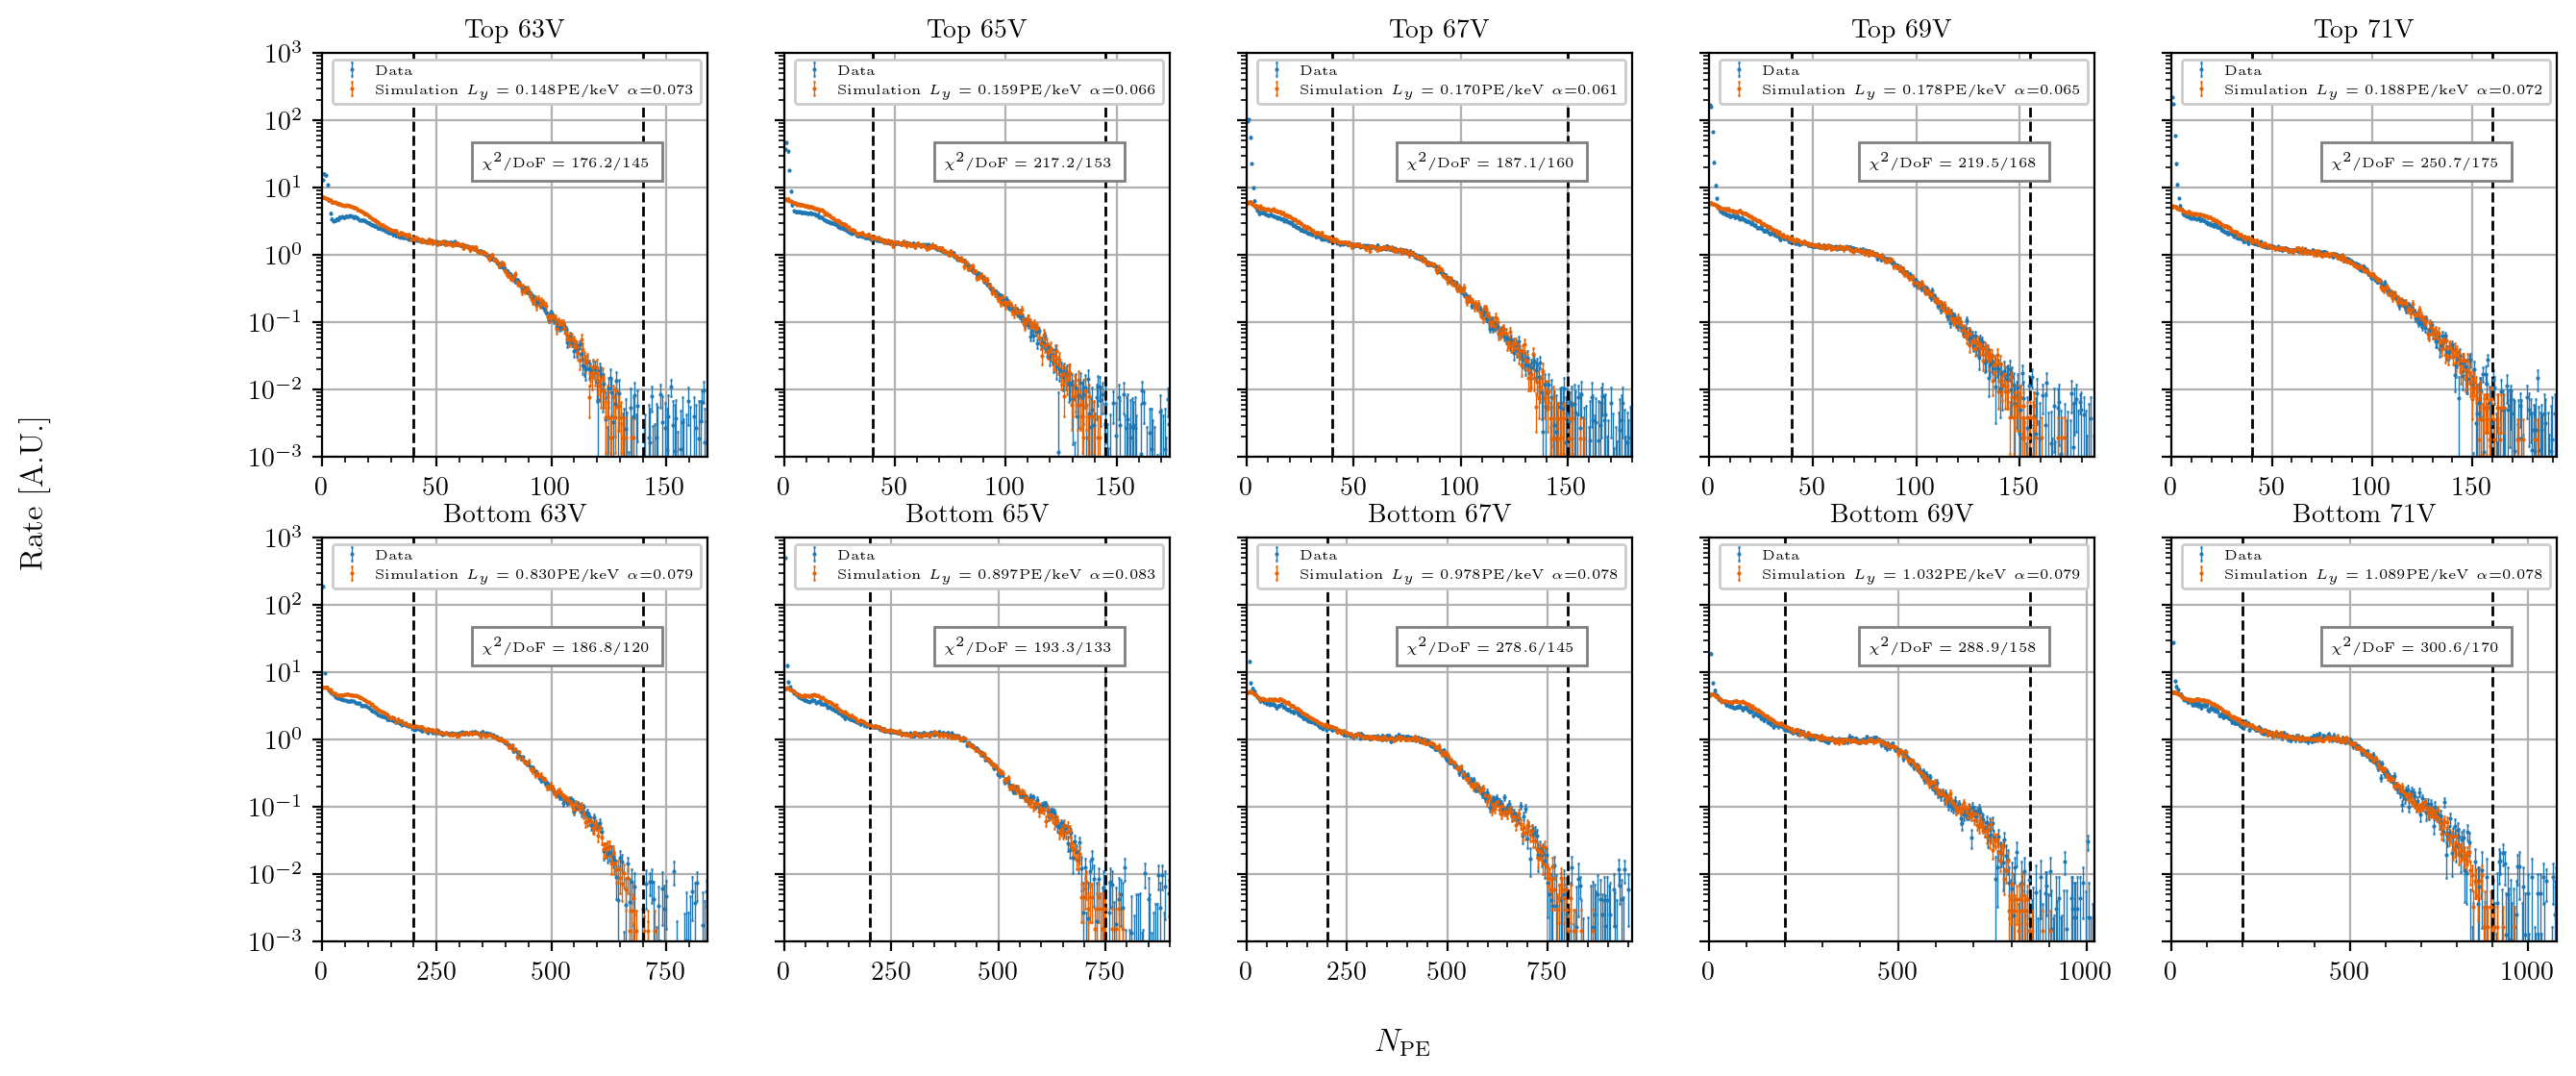

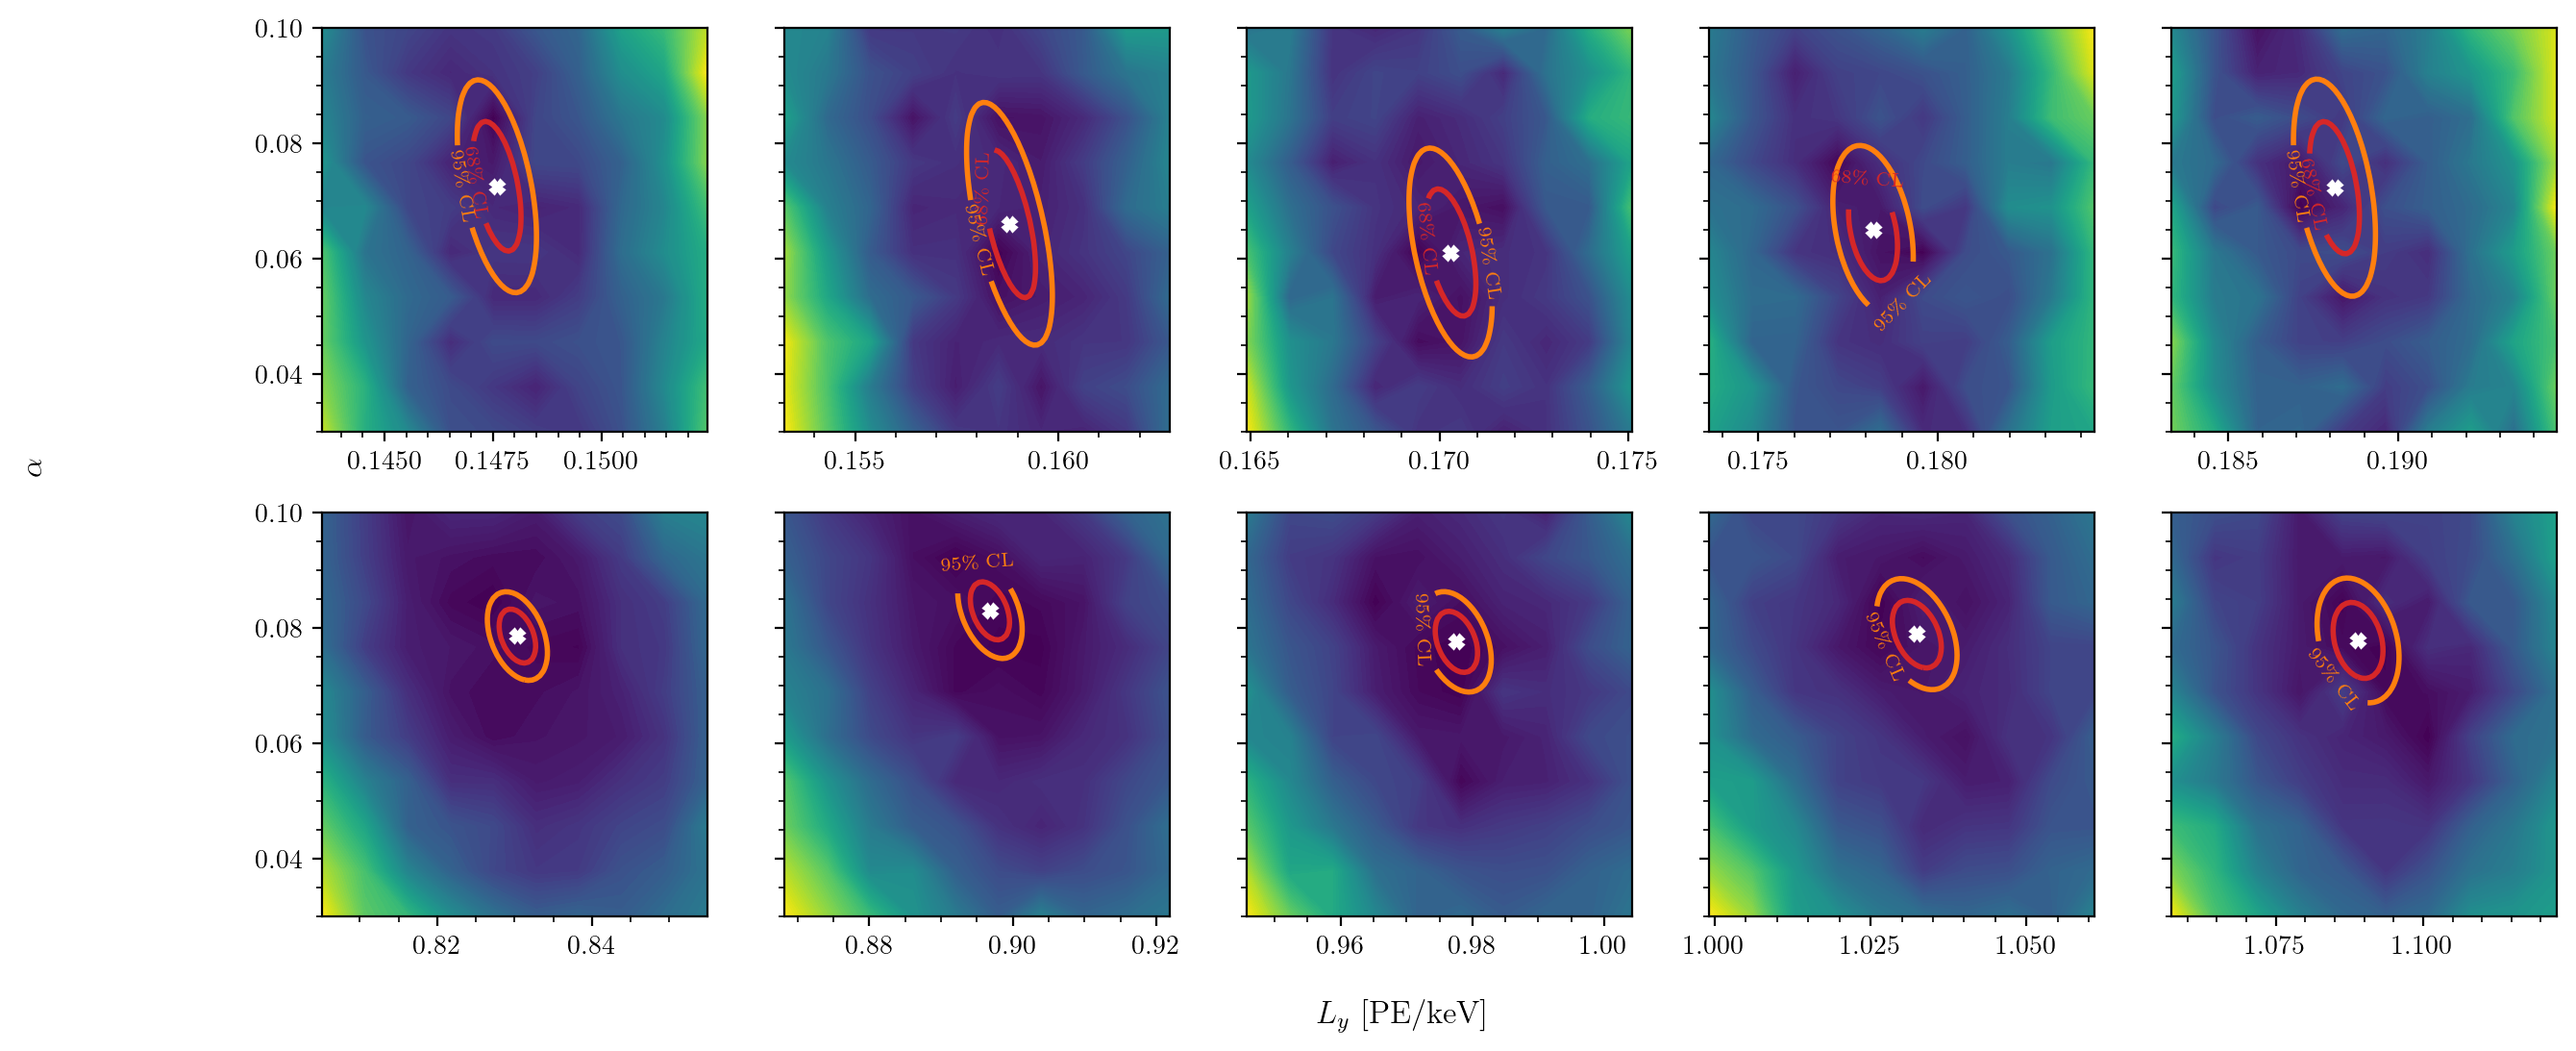

In [114]:
# Make plots for all datasets
# Fitted spectra
fig, axs = plt.subplots(2, 5, sharex=False, sharey=True)
fig.set_size_inches(15, 6)
ymin = 1e-3
ymax = 1e3
for i,pos in enumerate(positions):
    for j,volt in enumerate(voltages):
        axs[i,j].errorbar(
            spectrum_fit[pos][volt]['data']['x'],
            spectrum_fit[pos][volt]['data']['y'],
            yerr=spectrum_fit[pos][volt]['data']['yerr'],
            fmt='o', label='Data', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5
        )
        axs[i,j].errorbar(
            spectrum_fit[pos][volt]['sim']['x'],
            spectrum_fit[pos][volt]['sim']['y'], 
            yerr=spectrum_fit[pos][volt]['sim']['yerr'], 
            label=r'Simulation $L_y={:.3f}$PE/keV $\alpha$={:.3f}'.format(spectrum_fit[pos][volt]['ly'], spectrum_fit[pos][volt]['alpha']), 
            fmt='o', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5
        )
        axs[i,j].plot([spectrum_fit[pos][volt]['fit_range'][0]]*2, [ymin, ymax], 'k--', linewidth=1)
        axs[i,j].plot([spectrum_fit[pos][volt]['fit_range'][1]]*2, [ymin, ymax], 'k--', linewidth=1)
        axs[i,j].text(
            spectrum_fit[pos][volt]['fit_range'][1]*0.5, 
            ymax/50, 
            r'$\chi^2/\rm DoF={:.1f}/{:.0f}$'.format(spectrum_fit[pos][volt]['chi2']['min_toy'],spectrum_fit[pos][volt]['chi2']['dof']), 
            fontsize=5,bbox=dict(facecolor='white',edgecolor='grey',alpha=1)
        )
        axs[i,j].grid()
        axs[i,j].minorticks_on()
        axs[i,j].set_yscale('log')
        axs[i,j].legend(loc='upper right', fontsize=5)
        axs[i,j].set_xlim(0, spectrum_fit[pos][volt]['fit_range'][1]*1.2)
        axs[i,j].set_ylim(ymin, ymax)
        axs[i,j].set_title(f'{pos[0].upper()}{pos[1:]} {volt}V')
fig.supxlabel(r'$N_{\rm PE}$')
fig.supylabel('Rate [A.U.]')

# Chi square maps
fig2, axs2 = plt.subplots(2, 5, sharex=False, sharey=True)
fig2.set_size_inches(15, 6)
for i,pos in enumerate(positions):
    for j,volt in enumerate(voltages):
        axs2[i,j].contourf(
            spectrum_fit[pos][volt]['chi2']['x'],
            spectrum_fit[pos][volt]['chi2']['y'],
            spectrum_fit[pos][volt]['chi2']['z'],
            100
        )
        # axs2[i,j].colorbar(label=r'$\Delta\chi^2$')
        cs = axs2[i,j].contour(
            spectrum_fit[pos][volt]['chi2']['xfit'],
            spectrum_fit[pos][volt]['chi2']['yfit'],
            spectrum_fit[pos][volt]['chi2']['zfit'],
            [spectrum_fit[pos][volt]['chi2']['min_fit']-2*np.log(2*(1-norm.cdf(1,0,1))), spectrum_fit[pos][volt]['chi2']['min_fit']-2*np.log(2*(1-norm.cdf(2,0,1)))], 
            colors=['tab:red', 'tab:orange']
        )
        axs2[i,j].clabel(cs, fmt={cs.levels[0]:'68\% CL', cs.levels[1]:'95\% CL'},fontsize=7)
        axs2[i,j].plot([spectrum_fit[pos][volt]['ly']],[spectrum_fit[pos][volt]['alpha']],'wX', markersize=5)
        axs2[i,j].minorticks_on()
fig2.supxlabel(r'$L_y$ [PE/keV]')
fig2.supylabel(r'$\alpha$')

## Top-Bottom Comparison
The error bars for light yield (ratio) here include the contribution from calibration (SPE gain and DiCT probability)

In [115]:
# Initialize container
results = {
    'ly':{
        'Tyvek':{},'ESR':{}
    }, 
    'alpha':{
        'Tyvek':{},'ESR':{}
    },
    'ly_ratio':{
        'theory':{}, 'experiment':{}    
    }
}

Average Tyvek-to-ESR Ly ratio = 0.1758+/-0.0088(stat)+/-0.0024(sys)


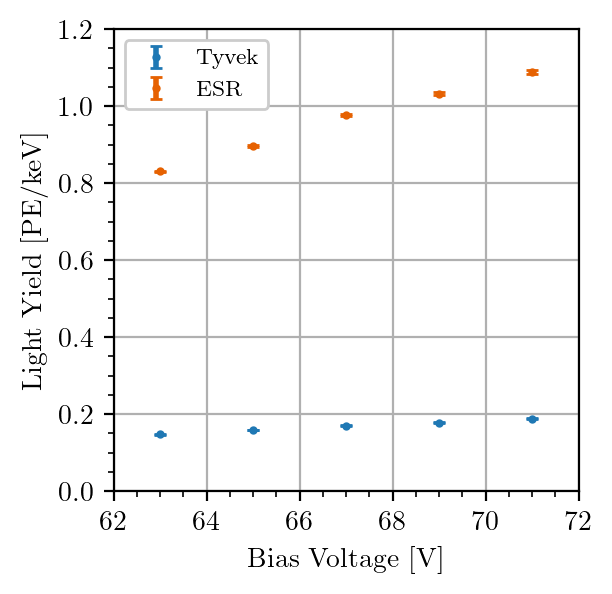

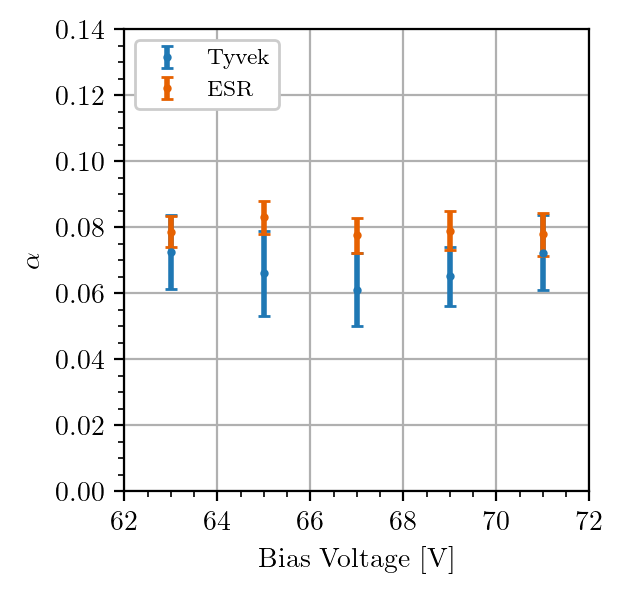

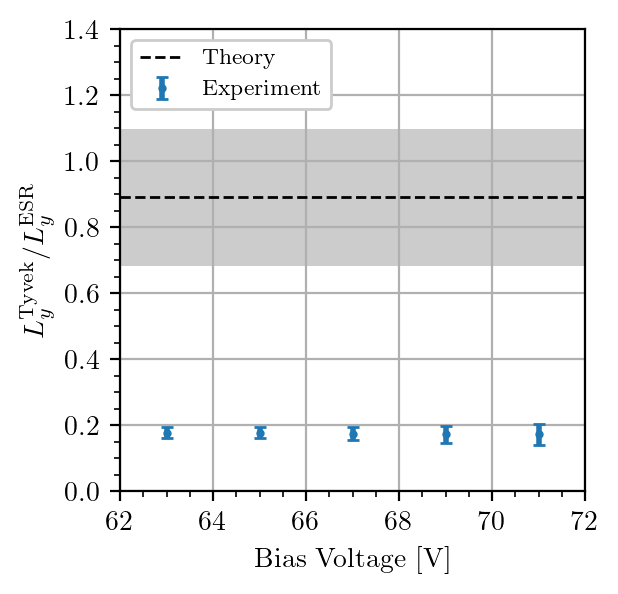

In [116]:
ly_ratio_th = 0.890
ly_ratio_th_err = 0.209

for k1 in list(results.keys()):
    for k2,pos in zip(list(results[k1].keys()),positions):
        if k1=='ly' or k1=='alpha':
            results[k1][k2]['x'] = voltages
            results[k1][k2]['y'] = np.array([spectrum_fit[pos][volt][k1] for volt in voltages])
            results[k1][k2]['yerr'] = np.array([spectrum_fit[pos][volt][k1+'_err'] for volt in voltages])
        elif k1=='ly_ratio':
            if k2=='theory':
                results[k1][k2]['x'] = np.array([voltages[0]-1, voltages[-1]+1])
                results[k1][k2]['y'] = np.array([ly_ratio_th]*2)
                results[k1][k2]['yerr'] = np.array([ly_ratio_th_err]*2)
            elif k2=='experiment':
                results[k1][k2]['x'] = np.array(voltages)
                results[k1][k2]['y'] = np.array([spectrum_fit['top'][volt]['ly']/spectrum_fit['bottom'][volt]['ly'] for volt in voltages])
                results[k1][k2]['yerr'] = np.array([
                (  
                    (spectrum_fit['top'][volt]['ly_err']/spectrum_fit['top'][volt]['ly'])**2 + 
                    syserr2['top'][volt] + 
                    (spectrum_fit['bottom'][volt]['ly_err']/spectrum_fit['bottom'][volt]['ly'])**2 + 
                    syserr2['bottom'][volt]
                )**0.5 for volt in voltages
                ])

plt.figure(1,figsize=(3,3))
labels = {'top':'Tyvek','bottom':'ESR'}
for ref in list(results['ly'].keys()):   
    plt.errorbar(
        results['ly'][ref]['x'],
        results['ly'][ref]['y'],
        yerr=results['ly'][ref]['yerr'], 
        fmt='o', label=ref, ls='none', elinewidth=2, capsize=2, markersize=2
    )
plt.xlabel(r'Bias Voltage [$\rm V$]')
plt.ylabel(r'Light Yield [$\rm PE/keV$]')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.xlim(62,72)
plt.ylim(0,1.2)

plt.figure(2,figsize=(3,3))
for ref in list(results['alpha'].keys()):   
    plt.errorbar(
        results['alpha'][ref]['x'],
        results['alpha'][ref]['y'],
        yerr=results['alpha'][ref]['yerr'], 
        fmt='o', label=ref, ls='none', elinewidth=2, capsize=2, markersize=2
    )
plt.xlabel(r'Bias Voltage [$\rm V$]')
plt.ylabel(r'$\alpha$')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.xlim(62,72)
plt.ylim(0,0.14)

plt.figure(3,figsize=(3,3))
plt.errorbar(
    results['ly_ratio']['experiment']['x'],
    results['ly_ratio']['experiment']['y'],
    yerr=results['ly_ratio']['experiment']['yerr'], 
    fmt='o', label='Experiment', ls='none', elinewidth=2, capsize=2, markersize=2
)
plt.fill_between(
    x=results['ly_ratio']['theory']['x'],
    y1=results['ly_ratio']['theory']['y']-results['ly_ratio']['theory']['yerr'], 
    y2=results['ly_ratio']['theory']['y']+results['ly_ratio']['theory']['yerr'],
    facecolor='k',alpha=0.2
)
plt.plot(
    results['ly_ratio']['theory']['x'], 
    results['ly_ratio']['theory']['y'], 
    'k--', label='Theory', linewidth=1
)
plt.xlabel(r'Bias Voltage [$\rm V$]')
plt.ylabel(r'$L_{y}^{\rm Tyvek}/L_{y}^{\rm ESR}$')
plt.grid()
plt.minorticks_on()
plt.legend()
plt.xlim(62,72)
plt.ylim(0,1.4)

# Weighted average and statistical uncertainty
lyr_mu = np.sum(results['ly_ratio']['experiment']['y']/results['ly_ratio']['experiment']['yerr']**2) \
    /np.sum(1/results['ly_ratio']['experiment']['yerr']**2)
lyr_sigma = 1/np.sqrt(np.sum(1/results['ly_ratio']['experiment']['yerr']**2))
# RMS variation -> "systematic" uncertainty
lyr_rms = np.std(results['ly_ratio']['experiment']['y'], ddof=1)
print(f'Average Tyvek-to-ESR Ly ratio = {lyr_mu:.4f}+/-{lyr_sigma:.4f}(stat)+/-{lyr_rms:.4f}(sys)')


# Coincidence settings

In [22]:
# Coincidence table
#      high trg rate <---------> low trg rate
# c0-3 OOO  AOO  OAO  OOA  AAO  AOA  OAA  AAA

# 0000 ---  ---  ---  ---  ---  ---  ---  --- 
# 1000 OOO  ---  OAO  ---  ---  ---  ---  --- 
# 0100 OOO  ---  OAO  ---  ---  ---  ---  --- 
# 0010 OOO  AOO  ---  ---  ---  ---  ---  ---
# 0001 OOO  AOO  ---  ---  ---  ---  ---  --- 
# 1100 OOO  AOO  OAO  ---  AAO  ---  ---  --- 
# 1010 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 1001 OOO  AOO  OAO  OOA  ---  ---  ---  --- 
# 0110 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 0101 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 0011 OOO  AOO  OAO  ---  AAO  ---  ---  ---
# 1110 OOO  AOO  OAO  OOA  AAO  AOA  ---  --- 
# 1101 OOO  AOO  OAO  OOA  AAO  AOA  ---  --- 
# 1011 OOO  AOO  OAO  OOA  AAO  ---  OAA  --- 
# 0111 OOO  AOO  OAO  OOA  AAO  ---  OAA  --- 
# 1111 OOO  AOO  OAO  OOA  AAO  AOA  OAA  AAA 

In [122]:
# data folder
data = {}
coinc = ['000', '100', '001', '110', '011', '111']
path = ["/scratch/gpfs/as111/results/2022-11-17/"]*5+["/scratch/gpfs/as111/results/2022-11-15/"]
for p,c in zip(path,coinc):
    data[c] = []
    files = glob.glob(f"{p}/*coinc_{c}*.h5")
    for f in files:
        df = pd.read_hdf(f, key='65')
        data[c].append(df)
        df = None
    data[c] = pd.concat(data[c], ignore_index=True)
print('keys: ', list(data['000'].keys()))
print(f'{len(data["000"])} events')

keys:  ['total_pe', 'fprompt']
1014577 events


In [123]:
# Initialize container
spectra_coinc = {}
for c in coinc:
    spectra_coinc[c] = {}

In [124]:
xmin = 0
xmax = 500
nbins = 750
norm_bound = 150

for c in coinc:
    spectra_coinc[c]['counts'],spectra_coinc[c]['bins'] = np.histogram(data[c]['total_pe'], bins=nbins, range=(xmin, xmax))
    data[c] = None
    spectra_coinc[c]['norm_bound'] = norm_bound
    spectra_coinc[c]['norm'] = np.dot(spectra_coinc[c]['bins'][:-1]>norm_bound, spectra_coinc[c]['counts'])
data = None

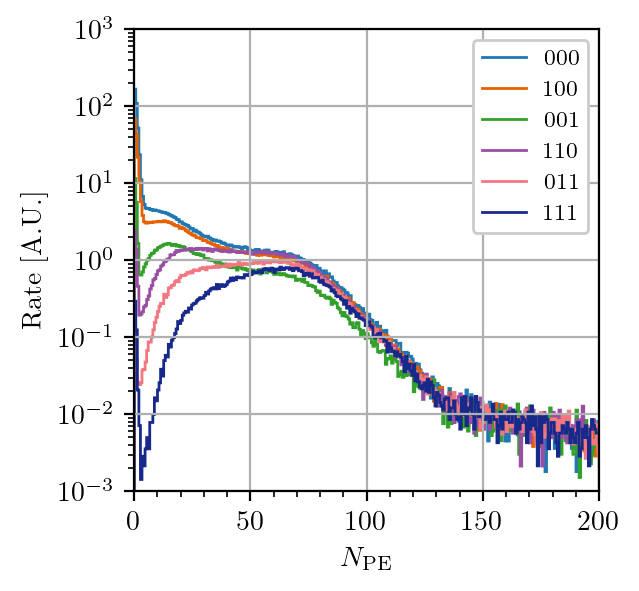

In [125]:
plt.figure(0,figsize=(3,3))
for c in coinc:
    plt.stairs(
        spectra_coinc[c]['counts']/spectra_coinc[c]['norm'], 
        spectra_coinc[c]['bins'], 
        label=c
    )
    
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel(r'$N_{\rm PE}$')
plt.legend(loc='upper right')
plt.xlim(0,200)
plt.ylim(1e-3,1e3)
plt.minorticks_on()
plt.grid()